# $\mathcal{Note \,\, Book \, \, Overview}$
1. $\mathcal{Check \,\,the\,\, activating \,\,state\, of}$ `gbook` & `pbook`:对于`gbook`和`pbook`自身性质进行研究，比如状态向量间的相似度、正交性等等。并附有给定Grid/HPC细胞在全空间的激活状态可视化。
2. `在线 RLS 根据频次分布重绑`:online-pseudo代替直接伪逆的测试部分。可视化展示了重建相似度与训练次数之间的关系。
3. `沿既定路径对内部表征的回放/重构:`研究沿着`snakepath`进行的回忆的重建率等等。本质上是copy了源代码，主要起了一个熟悉代码的功能，没有新的测试。$\textcolor{red}{额外的可视化:研究V对Grid Cell群体激活Pattern的影响}$
4. $\mathcal{Way\,\, of\,\, Sequence\,\, Memory}$:此处主要研究不同沿序列行走的方式与Sensory上信息复原情况。并研究了一整个pipeline不同的“启动方式”与对应各步的重建误差。 **纯Grid驱动（Grid-only）**、**Grid+Sensory混合（Grid+Sensory）**、 **Sensory启动Grid驱动（Sensory-initiated Grid）**
5. `分析为什么不同路径会导致不同的重建率`:对补充材料引理D.1 & D.2的思考与验证。

### $\texttt{PLOT STYLE AND PACKAGE IMPORT}$

In [12]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
# 仅一次加载自定义样式
plt.style.use('./src/presentation.mplstyle')
# 最终的字体覆盖（一定放在 style.use 之后）
matplotlib.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    # 备用无衬线，防止别处引用 'sans-serif' 时又回去找 Helvetica
    "font.sans-serif": ["DejaVu Sans", "Arial", "Microsoft YaHei", "SimHei"],
    "axes.unicode_minus": False
})

from numpy.random import randn
from numpy.random import randint
from tqdm import tqdm as tqdm
from src.assoc_utils_np import train_gcpc
from src.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d
from src.seq_utils import *
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

## $\mathcal{Check \,\,the\,\, activating \,\,state\, of}$ `gbook` & `pbook`

### 基本结构生成
- 下一格Cell还是在生成`gbook`和`pbook`
- `gbook`到`pbook`非常简单：乘以一个随机**稀疏**矩阵`Wpg`，再过一个`nonlin`的函数。

In [13]:
nruns=1
Np = 342 #400
lambdas = [3,4,5,7] #[3,4,5] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook.shape     # (Ng, Npos, Npos)
# module_sizes = np.square(lambdas)
# module_gbooks = [np.eye(i) for i in module_sizes]

Wpg = randn(nruns, Np, Ng) 
c = 0.10     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)
thresh = 2.0  #2.5 
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  # (nruns, Np, Npos, Npos) 
gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)
print(pbook_flattened.shape, gbook_flattened.shape)


(1, 342, 176400) (99, 176400)


### 空间中的Activating State


#### 检测是否存在完全相同的激活状态

In [ ]:
# 检测 gbook 中的相同向量
def find_duplicate_vectors_gbook(gbook):
    """
    检测 gbook 中是否存在相同的向量
    gbook 形状: (Ng, Npos, Npos)
    返回: 重复向量的统计信息
    """
    Ng, Npos, _ = gbook.shape
    total_positions = Npos * Npos
    
    # 将 gbook 重塑为 (Ng, Npos*Npos)，每列是一个位置的向量
    gbook_2d = gbook.reshape(Ng, total_positions)
    
    # 使用字典来跟踪每个唯一向量及其出现的位置
    vector_dict = {}
    duplicates = []
    
    for pos_idx in range(total_positions):
        # 获取当前位置的向量（转换为元组以便哈希）
        vector = tuple(gbook_2d[:, pos_idx])
        
        if vector in vector_dict:
            # 找到重复向量
            original_pos = vector_dict[vector]
            duplicates.append({
                'vector': vector,
                'positions': [original_pos, pos_idx],
                'coordinates': [
                    (original_pos // Npos, original_pos % Npos),
                    (pos_idx // Npos, pos_idx % Npos)
                ]
            })
        else:
            vector_dict[vector] = pos_idx
    
    return {
        'total_positions': total_positions,
        'unique_vectors': len(vector_dict),
        'duplicate_count': len(duplicates),
        'duplicates': duplicates
    }

# 检测 pbook 中的相同向量
def find_duplicate_vectors_pbook(pbook):
    """
    检测 pbook 中是否存在相同的向量
    pbook 形状: (nruns, Np, Npos, Npos)
    返回: 重复向量的统计信息
    """
    nruns, Np, Npos, _ = pbook.shape
    total_positions = Npos * Npos
    
    results = []
    
    for run in range(nruns):
        # 将当前 run 的 pbook 重塑为 (Np, Npos*Npos)
        pbook_2d = pbook[run].reshape(Np, total_positions)
        
        vector_dict = {}
        duplicates = []
        
        for pos_idx in range(total_positions):
            # 获取当前位置的向量
            vector = tuple(pbook_2d[:, pos_idx])
            
            if vector in vector_dict:
                original_pos = vector_dict[vector]
                duplicates.append({
                    'vector': vector,
                    'positions': [original_pos, pos_idx],
                    'coordinates': [
                        (original_pos // Npos, original_pos % Npos),
                        (pos_idx // Npos, pos_idx % Npos)
                    ]
                })
            else:
                vector_dict[vector] = pos_idx
        
        results.append({
            'run': run,
            'total_positions': total_positions,
            'unique_vectors': len(vector_dict),
            'duplicate_count': len(duplicates),
            'duplicates': duplicates
        })
    
    return results

# 执行检测
print("=== 检测 gbook 中的重复向量 ===")
gbook_result = find_duplicate_vectors_gbook(gbook)
print(f"总位置数: {gbook_result['total_positions']}")
print(f"唯一向量数: {gbook_result['unique_vectors']}")
print(f"重复向量数: {gbook_result['duplicate_count']}")

if gbook_result['duplicate_count'] > 0:
    print("\n前5个重复向量的详细信息:")
    for i, dup in enumerate(gbook_result['duplicates'][:5]):
        print(f"重复向量 {i+1}:")
        print(f"  出现位置: {dup['coordinates'][0]} 和 {dup['coordinates'][1]}")
        print(f"  向量值: {dup['vector'][:10]}{'...' if len(dup['vector']) > 10 else ''}")

print("\n=== 检测 pbook 中的重复向量 ===")
pbook_results = find_duplicate_vectors_pbook(pbook)

for run_result in pbook_results:
    print(f"\nRun {run_result['run']}:")
    print(f"  总位置数: {run_result['total_positions']}")
    print(f"  唯一向量数: {run_result['unique_vectors']}")
    print(f"  重复向量数: {run_result['duplicate_count']}")
    
    if run_result['duplicate_count'] > 0:
        print(f"  前3个重复向量的详细信息:")
        for i, dup in enumerate(run_result['duplicates'][:3]):
            print(f"    重复向量 {i+1}: 位置 {dup['coordinates'][0]} 和 {dup['coordinates'][1]}")

# 统计摘要
print("\n=== 统计摘要 ===")
print(f"gbook 重复率: {gbook_result['duplicate_count'] / gbook_result['total_positions'] * 100:.4f}%")

total_pbook_duplicates = sum(run['duplicate_count'] for run in pbook_results)
total_pbook_positions = sum(run['total_positions'] for run in pbook_results)
print(f"pbook 总体重复率: {total_pbook_duplicates / total_pbook_positions * 100:.4f}%")


=== 检测 gbook 中的重复向量 ===
总位置数: 176400
唯一向量数: 176400
重复向量数: 0

=== 检测 pbook 中的重复向量 ===

Run 0:
  总位置数: 176400
  唯一向量数: 176400
  重复向量数: 0

=== 统计摘要 ===
gbook 重复率: 0.0000%
pbook 总体重复率: 0.0000%


#### 检测是否相邻位置的`g & p`相似度更高 
- 最后的结果是相似位置的相似度远低于随机位置
- 并且统计结果显著

In [ ]:
# 完全重新设计 - 避免嵌套函数中的导入问题
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 先定义所有需要的函数（不嵌套）
def get_adjacent_positions(center_idx, Npos, radius=1):
    """获取相邻位置索引"""
    center_x = center_idx // Npos
    center_y = center_idx % Npos
    
    adjacent = []
    for dx in range(-radius, radius+1):
        for dy in range(-radius, radius+1):
            if dx == 0 and dy == 0:
                continue
            new_x = center_x + dx
            new_y = center_y + dy
            if 0 <= new_x < Npos and 0 <= new_y < Npos:
                adjacent.append(new_x * Npos + new_y)
    return adjacent

def compute_similarities(vector1, vector2, metric='cosine'):
    """计算向量相似度"""
    if metric == 'cosine':
        return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    elif metric == 'euclidean':
        return 1 / (1 + np.linalg.norm(vector1 - vector2))
    elif metric == 'pearson':
        return np.corrcoef(vector1, vector2)[0, 1]

def analyze_gbook_similarity(gbook_flattened, Npos, n_samples=1000):
    """专门分析gbook的相似性"""
    print("  分析gbook中...")
    ng, total_pos = gbook_flattened.shape
    
    # 设置随机种子
    rng = np.random.RandomState(42)
    center_positions = rng.choice(total_pos, size=min(n_samples, total_pos), replace=False)
    
    adjacent_similarities = []
    random_similarities = []
    
    for i, center_pos in enumerate(center_positions):
        if i % 100 == 0:
            print(f"    进度: {i+1}/{len(center_positions)}")
        
        center_vector = gbook_flattened[:, center_pos]
        
        # 相邻位置相似度
        adjacent_pos = get_adjacent_positions(center_pos, Npos, radius=1)
        if len(adjacent_pos) > 0:
            for adj_pos in adjacent_pos[:4]:  # 4个最近邻
                adj_vector = gbook_flattened[:, adj_pos]
                sim = compute_similarities(center_vector, adj_vector, 'cosine')
                adjacent_similarities.append(sim)
        
        # 随机位置相似度
        random_pos = rng.choice(total_pos, size=10, replace=False)
        for rand_pos in random_pos:
            if rand_pos != center_pos:
                rand_vector = gbook_flattened[:, rand_pos]
                sim = compute_similarities(center_vector, rand_vector, 'cosine')
                random_similarities.append(sim)
    
    return np.array(adjacent_similarities), np.array(random_similarities)

def analyze_pbook_similarity(pbook_flattened, Npos, n_samples=500):
    """专门分析pbook的相似性"""
    print("  分析pbook中...")
    nruns, Np, total_pos = pbook_flattened.shape
    pbook_data = pbook_flattened[0]  # 使用第一个run
    
    # 设置随机种子
    rng = np.random.RandomState(42)
    center_positions = rng.choice(total_pos, size=min(n_samples, total_pos), replace=False)
    
    adjacent_similarities = []
    random_similarities = []
    
    for i, center_pos in enumerate(center_positions):
        if i % 50 == 0:
            print(f"    进度: {i+1}/{len(center_positions)}")
        
        center_vector = pbook_data[:, center_pos]
        
        # 相邻位置相似度
        adjacent_pos = get_adjacent_positions(center_pos, Npos, radius=1)
        if len(adjacent_pos) > 0:
            for adj_pos in adjacent_pos[:4]:
                adj_vector = pbook_data[:, adj_pos]
                sim = compute_similarities(center_vector, adj_vector, 'cosine')
                adjacent_similarities.append(sim)
        
        # 随机位置相似度
        random_pos = rng.choice(total_pos, size=10, replace=False)
        for rand_pos in random_pos:
            if rand_pos != center_pos:
                rand_vector = pbook_data[:, rand_pos]
                sim = compute_similarities(center_vector, rand_vector, 'cosine')
                random_similarities.append(sim)
    
    return np.array(adjacent_similarities), np.array(random_similarities)

def perform_statistical_testing(adjacent_sim, random_sim, name=""):
    """执行统计检验"""
    print(f"  执行{name}统计检验...")
    
    # 基本统计量
    adj_mean = np.mean(adjacent_sim)
    adj_std = np.std(adjacent_sim)
    rand_mean = np.mean(random_sim)
    rand_std = np.std(random_sim)
    
    print(f"    相邻位置: {adj_mean:.4f} ± {adj_std:.4f} (n={len(adjacent_sim)})")
    print(f"    随机位置: {rand_mean:.4f} ± {rand_std:.4f} (n={len(random_sim)})")
    
    # t检验
    t_stat, p_value = stats.ttest_ind(adjacent_sim, random_sim)
    effect_size = (adj_mean - rand_mean) / np.sqrt((np.var(adjacent_sim) + np.var(random_sim)) / 2)
    
    print(f"    t统计量: {t_stat:.4f}")
    print(f"    p值: {p_value:.2e}")
    print(f"    效应量(Cohen's d): {effect_size:.4f}")
    
    return {
        'adjacent_similarities': adjacent_sim,
        'random_similarities': random_sim,
        'adjacent_mean': adj_mean,
        'random_mean': rand_mean,
        't_stat': t_stat,
        'p_value': p_value,
        'effect_size': effect_size
    }

# 主分析函数
def analyze_spatial_similarity_main(gbook_flattened, pbook_flattened, Npos, n_samples=1000):
    print("=== 相邻位置相似性科学验证 ===")
    print(f"位置空间: {Npos}×{Npos} = {Npos*Npos} 个位置")
    print(f"随机采样次数: {n_samples}")
    
    print("\n--- 分析 gbook ---")
    gbook_adj, gbook_rand = analyze_gbook_similarity(gbook_flattened, Npos, n_samples)
    gbook_stats = perform_statistical_testing(gbook_adj, gbook_rand, "gbook")
    
    print("\n--- 分析 pbook ---")
    pbook_adj, pbook_rand = analyze_pbook_similarity(pbook_flattened, Npos, n_samples)  # 减少样本加速
    pbook_stats = perform_statistical_testing(pbook_adj, pbook_rand, "pbook")
    
    return gbook_stats, pbook_stats

# 运行分析
print("开始相邻位置相似性分析...")
gbook_stats, pbook_stats = analyze_spatial_similarity_main(
    gbook_flattened, pbook_flattened, Npos, n_samples=1000
)

# 结果总结
print("\n=== 最终统计结果 ===")

def get_significance_level(p_value):
    if p_value < 0.001:
        return "极其显著***"
    elif p_value < 0.01:
        return "高度显著**"
    elif p_value < 0.05:
        return "显著*"
    else:
        return "不显著"

print("\n--- gbook 结果 ---")
print(f"相邻位置相似度: {gbook_stats['adjacent_mean']:.4f}")
print(f"随机位置相似度: {gbook_stats['random_mean']:.4f}")
print(f"差异: {gbook_stats['adjacent_mean'] - gbook_stats['random_mean']:.4f}")
print(f"p值: {gbook_stats['p_value']:.2e}")
print(f"效应量: {gbook_stats['effect_size']:.3f}")
print(f"显著性: {get_significance_level(gbook_stats['p_value'])}")

print("\n--- pbook 结果 ---")
print(f"相邻位置相似度: {pbook_stats['adjacent_mean']:.4f}")
print(f"随机位置相似度: {pbook_stats['random_mean']:.4f}")
print(f"差异: {pbook_stats['adjacent_mean'] - pbook_stats['random_mean']:.4f}")
print(f"p值: {pbook_stats['p_value']:.2e}")
print(f"效应量: {pbook_stats['effect_size']:.3f}")
print(f"显著性: {get_significance_level(pbook_stats['p_value'])}")



开始相邻位置相似性分析...
=== 相邻位置相似性科学验证 ===
位置空间: 420×420 = 176400 个位置
随机采样次数: 1000

--- 分析 gbook ---
  分析gbook中...
    进度: 1/1000
    进度: 101/1000
    进度: 201/1000
    进度: 301/1000
    进度: 401/1000
    进度: 501/1000
    进度: 601/1000
    进度: 701/1000
    进度: 801/1000
    进度: 901/1000
  执行gbook统计检验...
    相邻位置: 0.0000 ± 0.0000 (n=4000)
    随机位置: 0.0601 ± 0.1185 (n=10000)
    t统计量: -32.0790
    p值: 6.09e-218
    效应量(Cohen's d): -0.7174

--- 分析 pbook ---
  分析pbook中...
    进度: 1/1000
    进度: 51/1000
    进度: 101/1000
    进度: 151/1000
    进度: 201/1000
    进度: 251/1000
    进度: 301/1000
    进度: 351/1000
    进度: 401/1000
    进度: 451/1000
    进度: 501/1000
    进度: 551/1000
    进度: 601/1000
    进度: 651/1000
    进度: 701/1000
    进度: 751/1000
    进度: 801/1000
    进度: 851/1000
    进度: 901/1000
    进度: 951/1000
  执行pbook统计检验...
    相邻位置: 0.0298 ± 0.0467 (n=4000)
    随机位置: 0.0603 ± 0.0932 (n=10000)
    t统计量: -19.6998
    p值: 3.08e-85
    效应量(Cohen's d): -0.4132

=== 最终统计结果 ===

--- gbook 结果 ---
相邻位置相似度: 0.0000
随

#### Grid Cell v.s. Hpc

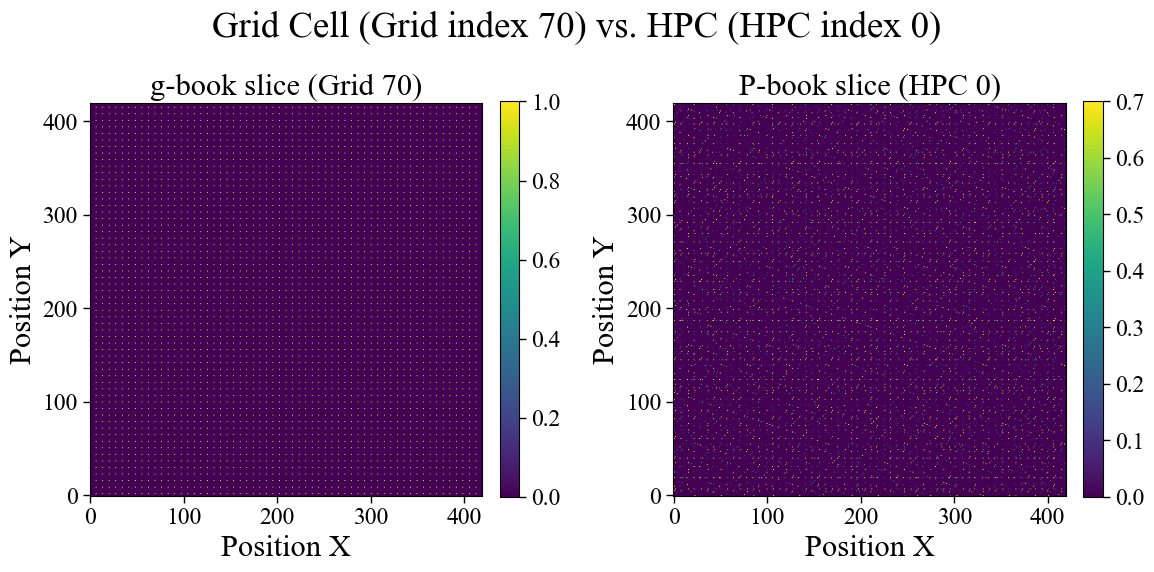

In [ ]:
# 二值化并并排展示原始与二值化的 P-book 切片
grid_idx = 70  # 选择要查看的 HPC 单元索引


slice_g = gbook[grid_idx, :, :]                 # 原始 420×420 切片
slice_g_binary = (slice_g != 0).astype(int)         # 二值化：非零即 1

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im0 = axes[0].imshow(slice_g, cmap="viridis", origin="lower", vmin=0,vmax=1)
axes[0].set_title(f"g-book slice (Grid {grid_idx})")
axes[0].set_xlabel("Position X")
axes[0].set_ylabel("Position Y")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

hpc_idx = 0  # 选择要查看的 HPC 单元索引

slice_420 = pbook[0, hpc_idx, :, :]                 # 原始 420×420 切片
slice_binary = (slice_420 != 0).astype(int)         # 二值化：非零即 1

im1 = axes[1].imshow(slice_420, cmap="viridis", origin="lower", vmin=0,vmax=0.7)
axes[1].set_title(f"P-book slice (HPC {hpc_idx})")
axes[1].set_xlabel("Position X")
axes[1].set_ylabel("Position Y")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# im1 = axes[1].imshow(slice_g_binary, cmap="gray_r", origin="lower", vmin=0, vmax=1)
# axes[1].set_title("Binarized slice (nonzero → 1)")
# axes[1].set_xlabel("Position X")
# axes[1].set_ylabel("Position Y")
# plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle(f"Grid Cell (Grid index {grid_idx}) vs. HPC (HPC index {hpc_idx})", y=0.95)
plt.tight_layout()
plt.show()

#### HPC V.S. Binarized HPC

In [ ]:
# 二值化并并排展示原始与二值化的 P-book 切片
hpc_idx = 0  # 选择要查看的 HPC 单元索引

slice_420 = pbook[0, hpc_idx, :, :]                 # 原始 420×420 切片
slice_binary = (slice_420 != 0).astype(int)         # 二值化：非零即 1

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im0 = axes[0].imshow(slice_420, cmap="viridis", origin="lower", vmin=0,vmax=1)
axes[0].set_title(f"P-book slice (HPC {hpc_idx})")
axes[0].set_xlabel("Position X")
axes[0].set_ylabel("Position Y")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(slice_binary, cmap="gray_r", origin="lower", vmin=0, vmax=1)
axes[1].set_title("Binarized slice (nonzero → 1)")
axes[1].set_xlabel("Position X")
axes[1].set_ylabel("Position Y")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle(f"P-book slice vs. binarized (HPC index {hpc_idx})", y=0.95)
plt.tight_layout()
plt.show()

#### Activation Count
- `gbook`的行/列的激活状态都是one-hot且按照$\lambda$排列
- `pbook`中的激活状态则是完全随机

In [ ]:
print("gbook:")
print(gbook_flattened)
# 统计 gbook 每行/每列1的个数
row_counts = gbook_flattened.sum(axis=1)  # 沿着列方向求和，得到每行的1的个数
col_counts = gbook_flattened.sum(axis=0)  # 沿着行方向求和，得到每列的1的个数
print("gbook每行1的个数:", row_counts)
print("gbook每列1的个数:", col_counts)
print("pbook:")
print(pbook_flattened)
# 由于第0维只有1个元素，可以先squeeze掉
pbook_2d = pbook_flattened.squeeze()  # 形状变为 (342, 176400)
# 统计每行非零元素个数
rows_nonzero = np.count_nonzero(pbook_2d, axis=1)  # 结果形状 (342,)
print("每行非零元素个数:", rows_nonzero)

# 统计每列非零元素个数  
cols_nonzero = np.count_nonzero(pbook_2d, axis=0)  # 结果形状 (176400,)
print("每列非零元素个数:", cols_nonzero)

## 在线 RLS 根据频次分布重绑
这个 demo 用**随机稀疏事件向量**表示“因/果事件”，然后维护 `count(effect|cause)` 的在线计数；每来一条样本就按当前排名把 effect 分配到 `cause` 附近的槽位，并用 RLS（`pseudotrain_2d_iterative_step`）增量更新 `Wps_demo/Wsp_demo`。

一点点数学：
- `theta`:
    $$
    \theta_k \approx (\epsilon^2 I + \sum_{i=1}^k a_i a_i^T)^{-1}
    $$
    $\sum_{i=1}^k a_i a_i^T$表示“到目前为止，输入在各个方向上出现过多少/多强”，取逆之后，得到“在某个方向上我还剩多少可塑性/不确定性”。最终的结果就是：某个方向的输入越常见，theta 在那个方向就越小，你以后就越不容易再被新样本推着大改。

    $\epsilon$越小，theta 越大，代表初期学习更快、权重更容易被写入;$\epsilon$ 越大，theta 越小，代表初期学习更保守、更不容易被新样本改写。

1. 槽位分配规则：cause 固定 (1,1)，effects 沿 x 轴为因果 (2, 1+r) 
2. 每输入一个样本就更新一次计数 `counts[eff] += 1`
3. 若槽位发生变化：记录并解除旧绑定(遗忘操作)
    ```python
    Wps_demo, theta_ps, *_ = rls_step(Wps_demo, theta_ps, s_e, np.zeros(Np))
    Wsp_demo, theta_sp, *_ = rls_step(Wsp_demo, theta_sp, p_old, np.zeros(Ns_demo))
    ```
4. 写入/强化：对当前排名 top-K 都做一次更新
5. 记录HPC上的几个放置Event的位置经过`Wsp@p`之后得到的sensory重建率

--- Online RLS re-binding demo (non-stationary stream) ---
phase1 size=90, phase2 size=90, switch_step=91
t=  1 counts={'E_wet': 0, 'E_rainbow': 1, 'E_bad_mood': 0} ranked=['E_rainbow', 'E_wet', 'E_bad_mood']
  E_wet      -> assigned=(2, 2), pred_best=(2, 2), scores=[1.000e-02 2.389e+01 1.150e+00]
  E_rainbow  -> assigned=(2, 1), pred_best=(2, 1), scores=[9.89 0.01 0.31]
  E_bad_mood -> assigned=(2, 3), pred_best=(2, 3), scores=[ 0.31  1.15 30.84]
t=  2 counts={'E_wet': 0, 'E_rainbow': 2, 'E_bad_mood': 0} ranked=['E_rainbow', 'E_wet', 'E_bad_mood']
  E_wet      -> assigned=(2, 2), pred_best=(2, 2), scores=[1.000e-02 2.392e+01 1.160e+00]
  E_rainbow  -> assigned=(2, 1), pred_best=(2, 1), scores=[9.9  0.01 0.31]
  E_bad_mood -> assigned=(2, 3), pred_best=(2, 3), scores=[ 0.31  1.16 30.88]
t=  5 counts={'E_wet': 1, 'E_rainbow': 3, 'E_bad_mood': 1} ranked=['E_rainbow', 'E_wet', 'E_bad_mood']
  E_wet      -> assigned=(2, 2), pred_best=(2, 2), scores=[1.000e-02 2.394e+01 1.160e+00]
  E_rainb

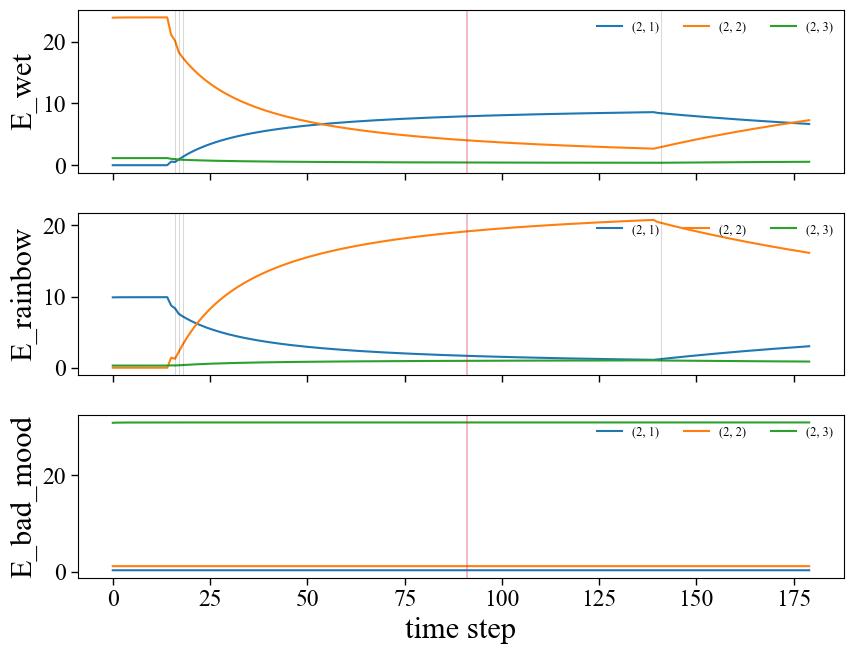

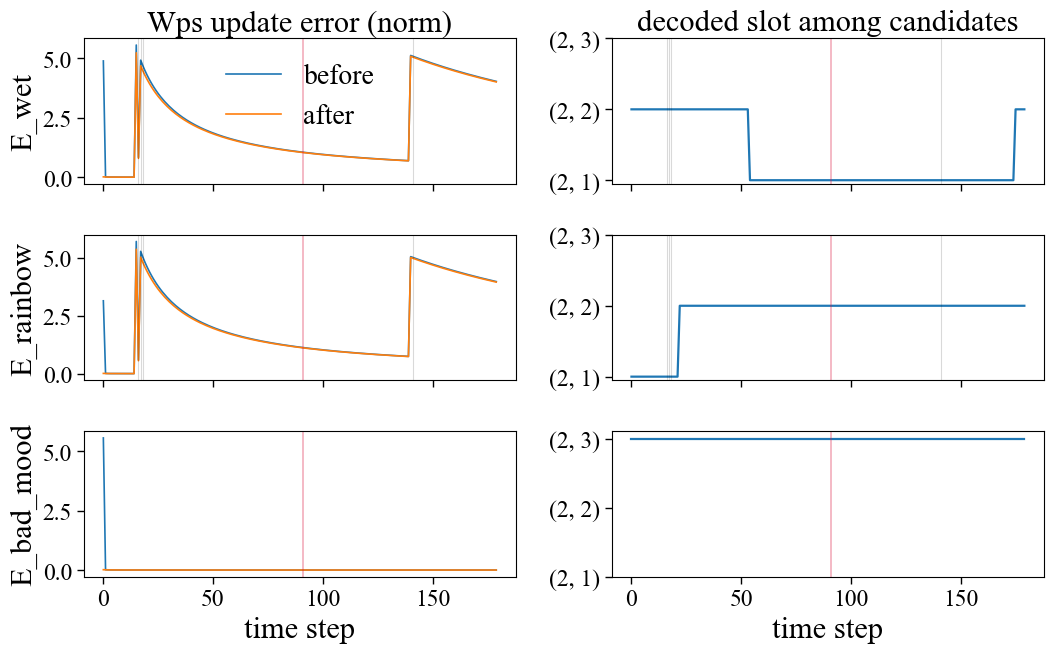

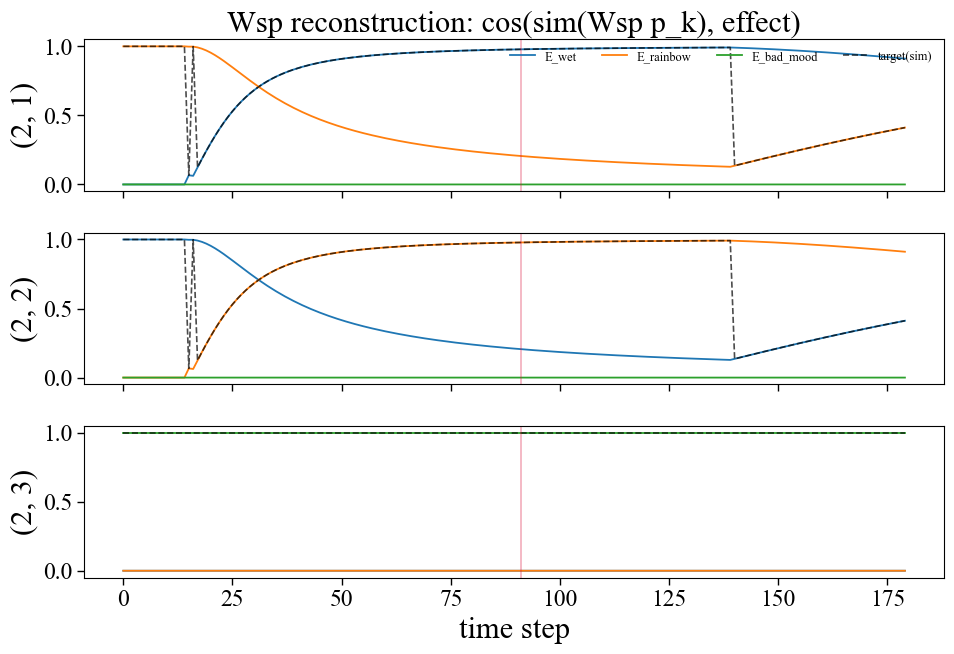

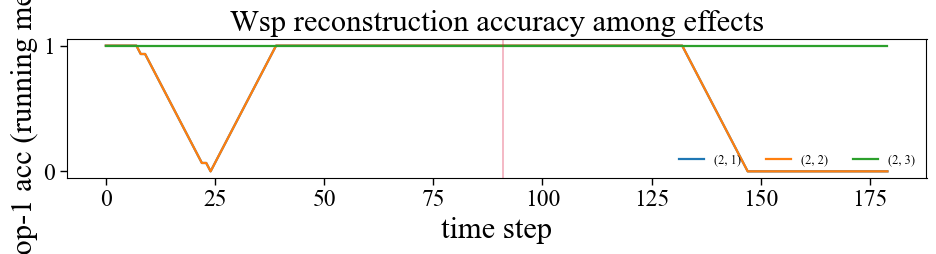

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 0) 依赖检查：沿用前面生成的 pbook / pbook_flattened / Npos / Np =====
assert 'pbook' in globals(), "需要先运行‘基本结构生成’得到 pbook"
assert 'Npos' in globals() and 'Np' in globals(), "需要先运行‘基本结构生成’得到 Npos/Np"
if 'pbook_flattened' not in globals():
    # pbook: (nruns, Np, Npos, Npos)
    pbook_flattened = pbook.reshape(pbook.shape[0], pbook.shape[1], Npos * Npos)
run = 0
P_all = pbook_flattened[run]  # (Np, Npos*Npos)

def flat_idx(x, y):
    return int(x * Npos + y)

def get_pvec(x, y):
    return P_all[:, flat_idx(x, y)]

# ===== 1) RLS 单步（返回可视化用的量） =====
# 和pseudotrain_2d_iterative_step(W, theta, ak, yk)一模一样
# 就是把中间步骤拆出来写了
def rls_step(W, theta, a, y):
    a = np.asarray(a).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)

    # 计算更新前预测与误差
    pred_before = W @ a
    err_before = y - pred_before

    #  计算“增益向量” bk
    #  a.T @ theta @ a  衡量“在输入方向 (a) 上，当前 theta 认为还有多少不确定/可塑性”
    #  theta @ a 给出更新倾向（在输入空间里该往哪里动）
    #  bk是针对这个输入样本的自适应学习率方向
    denom = 1.0 + (a.T @ theta @ a).item()
    bk = (theta @ a) / denom              # (dim(a), 1)

    # 更新“可塑性/不确定性”） 
    theta_new = theta - (theta @ a @ bk.T)

    # err_before @ bk.T 前者决定修正多少，后者决定修正方向
    W_new = W + (err_before @ bk.T)
    pred_after = W_new @ a
    err_after = y - pred_after
    return W_new, theta_new, float(np.linalg.norm(bk)), float(np.linalg.norm(err_before)), float(np.linalg.norm(err_after))

# ===== 2) 随机稀疏事件向量：cause + 3 effects =====
rng = np.random.default_rng(0)
Ns_demo = 512
k_sparse = 12
def make_sparse_vec(N, k, rng):
    v = np.zeros(N, dtype=float)
    idx = rng.choice(N, size=k, replace=False)
    v[idx] = rng.choice([-1.0, 1.0], size=k)
    v /= (np.linalg.norm(v) + 1e-12)
    return v

events = {
    'C_rain': make_sparse_vec(Ns_demo, k_sparse, rng),
    'E_wet': make_sparse_vec(Ns_demo, k_sparse, rng),
    'E_rainbow': make_sparse_vec(Ns_demo, k_sparse, rng),
    'E_bad_mood': make_sparse_vec(Ns_demo, k_sparse, rng),
}

# ===== 3) 槽位分配规则：cause 固定 (1,1)，effects 沿 x 轴为因果 (2, 1+r) =====
cause_anchor = (1, 1)
def slots_for_rank(r):
    x0, y0 = cause_anchor
    return (x0 + 1, y0 + r)
K = 3
candidate_slots = [slots_for_rank(r) for r in range(K)]
candidate_p = np.stack([get_pvec(x, y) for (x, y) in candidate_slots], axis=1)  # (Np, K)

def decode_among_candidates(p_hat):
    # 用点积/相似度在候选槽位里找最接近的
    scores = candidate_p.T @ p_hat.reshape(-1)  # (K,)
    best = int(np.argmax(scores))
    return best, scores

# ===== 4) 初始化：Wps_demo(s->p) / Wsp_demo(p->s) + theta =====
Wps_demo = np.zeros((Np, Ns_demo), dtype=float)
Wsp_demo = np.zeros((Ns_demo, Np), dtype=float)
epsilon = 0.05
theta_ps = (1.0 / (epsilon**2)) * np.eye(Ns_demo)
theta_sp = (1.0 / (epsilon**2)) * np.eye(Np)

# ===== 5) 在线样本流（非平稳）：前半段 E_wet 占优，后半段 E_rainbow 反超，触发重排 =====
phase1 = (['E_wet'] * 60) + (['E_rainbow'] * 20) + (['E_bad_mood'] * 10)
phase2 = (['E_rainbow'] * 80) + (['E_wet'] * 5) + (['E_bad_mood'] * 5)
rng.shuffle(phase1)
rng.shuffle(phase2)
stream = phase1 + phase2
switch_step = len(phase1) + 1  # 从这个 time step 开始进入 phase2
counts = {k: 0 for k in ['E_wet', 'E_rainbow', 'E_bad_mood']}
effects_order = ['E_wet', 'E_rainbow', 'E_bad_mood']
effect_to_j = {e: j for j, e in enumerate(effects_order)}
slot_of = {k: None for k in counts.keys()}

def current_ranking():
    fixed = ['E_wet', 'E_rainbow', 'E_bad_mood']
    return sorted(fixed, key=lambda e: (-counts[e], fixed.index(e)))

# 记录曲线：候选槽位分数 + RLS 误差 + 槽位变化时刻
history = {k: {'best': [], 'scores': [], 'assigned': [], 'err_before': [], 'err_after': []} for k in counts.keys()}
# 记录：给定 p(候选槽位) 经过 Wsp 得到的 s_hat，与三个 effect 的相似度（看耦合/串扰）
wsp_sim = np.zeros((len(stream), K, len(effects_order)), dtype=float)
# 记录：每个 time step、每个候选槽位，当前‘应该绑定’的 effect（用于定义重建率/准确率）
slot_target_idx = np.full((len(stream), K), -1, dtype=int)
slot_change_steps = {k: [] for k in counts.keys()}
milestones = set([1, 2, 5, 10, 20, 50, 80, len(phase1), switch_step, switch_step + 10, len(stream)])

print("--- Online RLS re-binding demo (non-stationary stream) ---")
print(f"phase1 size={len(phase1)}, phase2 size={len(phase2)}, switch_step={switch_step}")
for t, eff in enumerate(stream, start=1):
    # 1) 更新计数
    counts[eff] += 1
    ranked = current_ranking()
    target_slot = {e: slots_for_rank(r) for r, e in enumerate(ranked)}
    slot_to_effect = {xy: e for e, xy in target_slot.items()}
    for k in range(K):
        e_xy = slot_to_effect.get(candidate_slots[k], None)
        slot_target_idx[t-1, k] = effect_to_j[e_xy] if e_xy is not None else -1
    
    # 2) 若槽位发生变化：记录并解除旧绑定（让 demo 更直观）
    for e in ranked:
        new_xy = target_slot[e]
        old_xy = slot_of[e]
        if old_xy is not None and old_xy != new_xy:
            slot_change_steps[e].append(t)
            p_old = get_pvec(*old_xy)
            s_e = events[e]
            # 解除：把输出推向 0（在线遗忘的一种简化）
            Wps_demo, theta_ps, *_ = rls_step(Wps_demo, theta_ps, s_e, np.zeros(Np))
            Wsp_demo, theta_sp, *_ = rls_step(Wsp_demo, theta_sp, p_old, np.zeros(Ns_demo))
            slot_of[e] = None
    
    # 3) 写入/强化：对当前排名 top-K 都做一次更新（rehearsal）
    step_err = {}
    for r, e in enumerate(ranked[:K]):
        xy = target_slot[e]
        p_tgt = get_pvec(*xy)
        s_e = events[e]
        Wps_demo, theta_ps, bk_norm_ps, eb_ps, ea_ps = rls_step(Wps_demo, theta_ps, s_e, p_tgt)
        Wsp_demo, theta_sp, bk_norm_sp, eb_sp, ea_sp = rls_step(Wsp_demo, theta_sp, p_tgt, s_e)
        slot_of[e] = xy
        step_err[e] = (eb_ps, ea_ps)
    
    # 4) 记录每个 effect 当前的预测（在候选槽位中解码）
    for e in counts.keys():
        s_e = events[e]
        p_hat = Wps_demo @ s_e
        best, scores = decode_among_candidates(p_hat)
        history[e]['best'].append(best)
        history[e]['scores'].append(scores)
        history[e]['assigned'].append(target_slot[e])
        if e in step_err:
            eb, ea = step_err[e]
        else:
            eb, ea = (np.nan, np.nan)
        history[e]['err_before'].append(eb)
        history[e]['err_after'].append(ea)
    
    # 4.5) 记录 Wsp 的重建：固定三个候选 p 槽位，比较与三个 effect 的相似度（cosine）
    for k in range(K):
        p_k = candidate_p[:, k]
        s_hat = Wsp_demo @ p_k
        s_hat = s_hat.reshape(-1)
        denom = (np.linalg.norm(s_hat) + 1e-12)
        for j, e2 in enumerate(effects_order):
            # events[e2] 已经归一化，cosine = dot / ||s_hat||
            wsp_sim[t-1, k, j] = float((s_hat @ events[e2]) / denom)
    
    # 5) 里程碑打印：槽位目标 + 当前预测 + 分数
    if t in milestones:
        print(f"t={t:3d} counts={counts} ranked={ranked}")
        for e in ['E_wet', 'E_rainbow', 'E_bad_mood']:
            xy = target_slot[e]
            s_e = events[e]
            p_hat = Wps_demo @ s_e
            best, scores = decode_among_candidates(p_hat)
            print(f"  {e:10s} -> assigned={xy}, pred_best={candidate_slots[best]}, scores={np.round(scores, 2)}")

# ===== 6) 可视化A：每个 effect 在 3 个候选槽位上的分数随时间演化（越高越像） =====
fig, axes = plt.subplots(3, 1, figsize=(9, 7), sharex=True)
for ax, e in zip(axes, effects_order):
    S = np.stack(history[e]['scores'], axis=0)  # (T, K)
    for k in range(K):
        ax.plot(S[:, k], linewidth=1.5, label=str(candidate_slots[k]))
    for t0 in slot_change_steps[e]:
        ax.axvline(t0, color='k', linewidth=0.8, alpha=0.15)
    ax.axvline(switch_step, color='crimson', linewidth=1.2, alpha=0.35)
    ax.set_ylabel(e)
    ax.legend(frameon=False, fontsize=9, ncol=3, loc='upper right')
axes[-1].set_xlabel('time step')
plt.tight_layout()
plt.show()

# ===== 7) 可视化B：RLS 更新的误差下降（err_before vs err_after）+ 预测槽位序号 =====
fig, axes = plt.subplots(3, 2, figsize=(11, 7), sharex='col')
for i, e in enumerate(effects_order):
    eb = np.array(history[e]['err_before'], dtype=float)
    ea = np.array(history[e]['err_after'], dtype=float)
    axes[i, 0].plot(eb, label='before', linewidth=1.2)
    axes[i, 0].plot(ea, label='after', linewidth=1.2)
    for t0 in slot_change_steps[e]:
        axes[i, 0].axvline(t0, color='k', linewidth=0.8, alpha=0.15)
    axes[i, 0].axvline(switch_step, color='crimson', linewidth=1.2, alpha=0.35)
    axes[i, 0].set_ylabel(e)
    if i == 0:
        axes[i, 0].legend(frameon=False)
    # 预测槽位（0/1/2 对应 candidate_slots）
    axes[i, 1].plot(history[e]['best'], linewidth=1.6)
    axes[i, 1].set_yticks([0, 1, 2])
    axes[i, 1].set_yticklabels([str(s) for s in candidate_slots])
    for t0 in slot_change_steps[e]:
        axes[i, 1].axvline(t0, color='k', linewidth=0.8, alpha=0.15)
    axes[i, 1].axvline(switch_step, color='crimson', linewidth=1.2, alpha=0.35)
axes[-1, 0].set_xlabel('time step')
axes[-1, 1].set_xlabel('time step')
axes[0, 0].set_title('Wps update error (norm)')
axes[0, 1].set_title('decoded slot among candidates')
plt.tight_layout()
plt.show()

# ===== 8) 可视化C：Wsp(p->s) 重建相似度：固定候选 p 槽位，看 s_hat 与各 effect 的 cosine 相似度 =====
fig, axes = plt.subplots(K, 1, figsize=(10, 7), sharex=True)
if K == 1:
    axes = [axes]
for k, ax in enumerate(axes):
    for j, e2 in enumerate(effects_order):
        ax.plot(wsp_sim[:, k, j], linewidth=1.3, label=e2)
    # 目标 effect（该槽位当前应该绑定的）用点线标出来
    tgt = slot_target_idx[:, k]
    valid = tgt >= 0
    tgt_sim = np.full(len(stream), np.nan, dtype=float)
    tgt_sim[valid] = wsp_sim[np.arange(len(stream))[valid], k, tgt[valid]]
    ax.plot(tgt_sim, color='k', linewidth=1.2, linestyle='--', alpha=0.7, label='target(sim)')
    ax.axvline(switch_step, color='crimson', linewidth=1.2, alpha=0.35)
    ax.set_ylabel(str(candidate_slots[k]))
    if k == 0:
        ax.legend(frameon=False, fontsize=9, ncol=4, loc='upper right')
axes[-1].set_xlabel('time step')
axes[0].set_title('Wsp reconstruction: cos(sim(Wsp p_k), effect)')
plt.tight_layout()
plt.show()



### 环面流形与编码空间等效性验证
- 并顺带绘制了“作为离散吸引子的环面流形”

In [4]:
# ### 环面流形与编码空间等效性验证：边界环绕（wrap-around）检查
# 说明：gen_gbook_2d 里 gbook[:, x, y] 对应位置 (x, y)。
# - 向右（x+1）对应 axis=0, direction=+1
# - 向上（y+1）对应 axis=1, direction=+1


def _compare_gvec(g_a, g_b, name, atol=0.0):
    g_a = np.asarray(g_a).reshape(-1)
    g_b = np.asarray(g_b).reshape(-1)
    same_exact = np.array_equal(g_a, g_b)
    same_close = np.allclose(g_a, g_b, atol=atol, rtol=0.0)
    diff_norm = float(np.linalg.norm(g_a - g_b))
    print(f"{name}: exact={same_exact}, allclose={same_close}, ||diff||_2={diff_norm:.3g}")


# 目标状态：(0,0)
g_00 = gbook[:, 0, 0]


# 1) (Npos-1, 0) 向右一步：是否回到 (0,0)
Wgg_right = path_integration_Wgg_2d(lambdas, Ng, axis=0, direction=1)
g_start_1 = gbook[:, Npos - 1, 0]
g_next_1 = Wgg_right @ g_start_1
_compare_gvec(g_next_1, g_00, name="(Npos-1,0) --right--> (0,0)?")


# 2) (0, Npos-1) 沿 y 轴正方向一步（环面上等价于 y+1）：是否回到 (0,0)
Wgg_up = path_integration_Wgg_2d(lambdas, Ng, axis=1, direction=1)
g_start_2 = gbook[:, 0, Npos - 1]
g_next_2 = Wgg_up @ g_start_2
_compare_gvec(g_next_2, g_00, name="(0,Npos-1) --up(y+1)--> (0,0)?")

(Npos-1,0) --right--> (0,0)?: exact=True, allclose=True, ||diff||_2=0
(0,Npos-1) --up(y+1)--> (0,0)?: exact=True, allclose=True, ||diff||_2=0


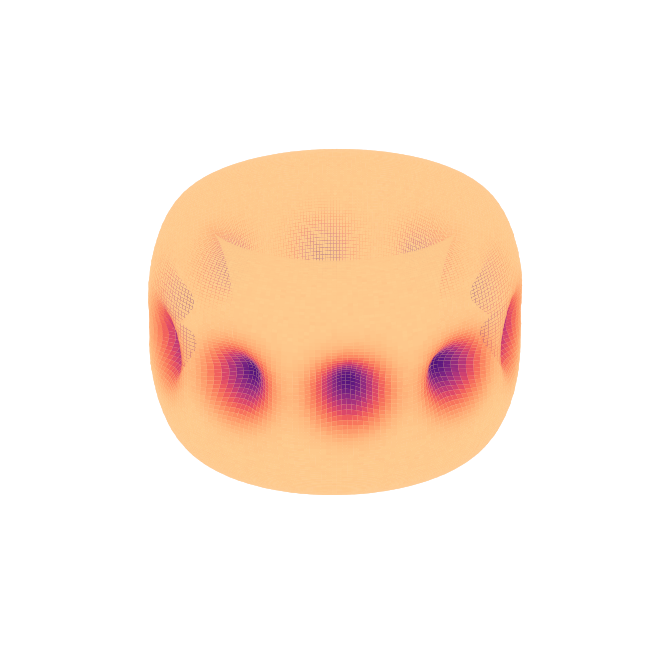

In [13]:
# 10 个沿大半径分布的坑，向甜甜圈中心内陷（坑更小，整体更扁）
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 网格
n_u, n_v = 220, 200
u = np.linspace(0, 2*np.pi, n_u)
v = np.linspace(0, 2*np.pi, n_v)
uu, vv = np.meshgrid(u, v)

# 基础半径（略降 r 以变扁）
R, r = 1.6, 0.48

# 坑中心：沿大半径方向等间隔 10 个
n_pits = 10
pit_us = np.linspace(0, 2*np.pi, n_pits, endpoint=False)
pit_vs = np.zeros(n_pits)
pit_centers = np.stack([pit_us, pit_vs], axis=1)

def ang_dist(a, b):
    return np.pi - np.abs(np.pi - np.abs(a - b))
def torus_gauss(uu, vv, uc, vc, su, sv):
    du = ang_dist(uu, uc)
    dv = ang_dist(vv, vc)
    return np.exp(-0.5 * ((du/su)**2 + (dv/sv)**2))

# 主要坑：缩小 R 方向，坑更小更尖
depth_R = np.zeros_like(uu)
sigma_u = 0.12  # 更小半径
sigma_v = 0.18
amp_R = -0.45
for uc, vc in pit_centers:
    depth_R += amp_R * torus_gauss(uu, vv, uc, vc, sigma_u, sigma_v)

# 轻微噪声
rng = np.random.default_rng(2)
depth_R += 0.002 * rng.normal(size=depth_R.shape)

# 仅修改大半径项，管半径保持 r（已减小）
R_local = R + depth_R
r_local = r

# 环面坐标，额外在 z 方向做轻微压缩让整体更扁
z_scale = 0.85
x = (R_local + r_local * np.cos(vv)) * np.cos(uu)
y = (R_local + r_local * np.cos(vv)) * np.sin(uu)
z = r_local * np.sin(vv) * z_scale

# 配色
cmap = plt.colormaps.get_cmap('magma')
normed = (depth_R - depth_R.min()) / (np.ptp(depth_R) + 1e-9)
colors = cmap(0.25 + 0.65 * normed)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=colors,
                linewidth=0, antialiased=True, shade=False)
ax.set_axis_off()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.view_init(elev=24, azim=32)
ax.set_box_aspect([1, 1, 0.6])
plt.tight_layout()

plt.show()

### 可视化类似Grid2009的Neural Population Activity

关键区别说明：
- **Grid2009的`r`矩阵 (128×128)**：表示128×128个神经元在空间中的排列，每个元素是某位置神经元的活动强度
- **JiLab_Test的`gbook` (Ng, Npos, Npos)**：表示Ng个网格细胞对Npos×Npos个位置的响应编码

***推测：*** 如何用`gbook`展现出六边形的Neural Sheet
1. 查看特定位置时所有网格细胞的激活（模拟群体响应）
2. Reshape成一个`2d`的`Array`

In [ ]:
######为什么选择这个数量？
######Grid 2009中，绘制的Neural Sheet是128×128
######考虑到Ng应该为周期数平方和，大约就是lambdas = [i for i in range(2,37)]
######但是值得一提的是，在Grid2009中，Neural Sheet中的激活亮点数量，大约是36*2

lambdas = [i for i in range(2,8)] #[3,4,5] 
Ng = np.sum(np.square(lambdas))

######这里不能用np.prod，因为数值太大，只能手动指定一个值了
Npos = np.prod(lambdas)
# Npos = 1000
gbook = gen_gbook_2d(lambdas, Ng, Npos)



方法2：查看特定位置的群体神经元活动


C:\Users\DELL\AppData\Local\Temp\ipykernel_12896\3997174154.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hot_cmap = plt.cm.get_cmap('hot')


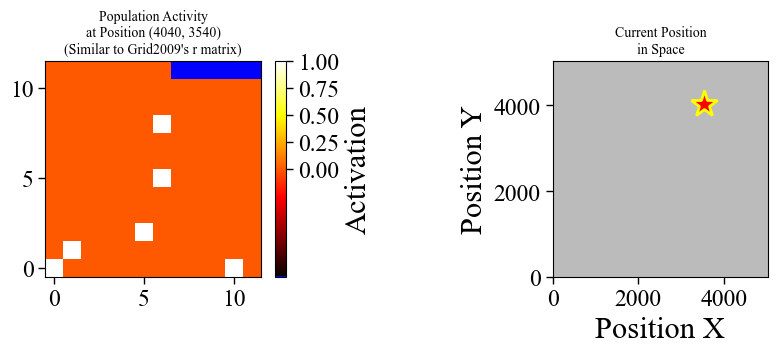

Position (4040, 3540):
  Active neurons: 6/139
  Activity rate: 4.32%
  Total activity: 6.00
  Padding cells: 5 (shown in blue)


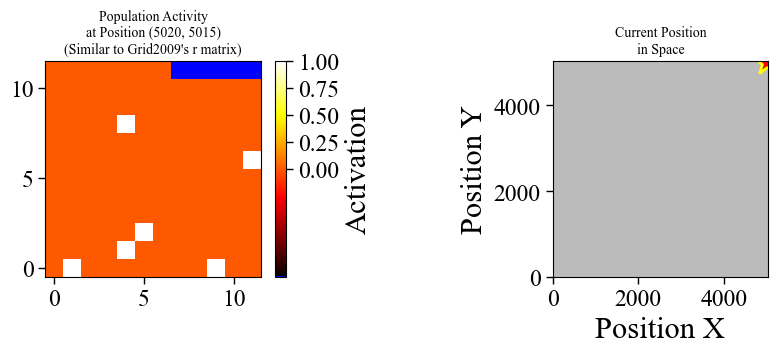

Position (5020, 5015):
  Active neurons: 6/139
  Activity rate: 4.32%
  Total activity: 6.00
  Padding cells: 5 (shown in blue)


In [18]:
# ====================================
# 方法2：可视化群体神经元活动（模拟Grid2009的r矩阵）
# ====================================
def visualize_population_activity_at_position(gbook, position, lambdas, figsize=(10, 4)):
    """
    在特定位置显示所有网格细胞的激活状态
    
    这模拟了Grid2009中某个时刻所有神经元的活动状态
    """
    Ng, Npos, _ = gbook.shape
    x, y = position
    
    # 提取所有网格细胞在当前位置的响应
    population_response = gbook[:, x, y]  # (Ng,)
    
    # 重塑为接近正方形的网格
    side = int(np.ceil(np.sqrt(Ng)))
    pad_size = side * side - Ng
    # 使用 -1 作为填充值的标记，用于后续识别
    response_padded = np.concatenate([population_response, 
                                      np.full(pad_size, -1)])
    neuron_sheet = response_padded.reshape(side, side)
    
    # 创建两个子图
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 创建自定义的 colormap：蓝色用于填充区域，hot colormap 用于实际数据
    from matplotlib.colors import ListedColormap
    import matplotlib.colors as mcolors
    
    # 获取 hot colormap
    hot_cmap = plt.cm.get_cmap('hot')
    # 为填充值（-1）添加蓝色
    colors = ['blue'] + [hot_cmap(i) for i in np.linspace(0, 1, 256)]
    custom_cmap = ListedColormap(colors)
    
    # 左图：神经元片层活动
    # 将 vmin 设为 -1.5 以确保 -1 映射到蓝色
    im0 = axes[0].imshow(neuron_sheet, cmap=custom_cmap, origin='lower', 
                        interpolation='nearest', vmin=-1, vmax=1)
    cbar = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label='Activation')
    # 调整 colorbar 刻度，隐藏负值部分
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    
    axes[0].set_title(f'Population Activity\nat Position ({x}, {y})\n'
                     f'(Similar to Grid2009\'s r matrix)', fontsize=10)
    # axes[0].set_xlabel('Neuron Grid X')
    # axes[0].set_ylabel('Neuron Grid Y')
    
    # 右图：在空间地图上标记当前位置
    # 随机选择一个网格细胞来显示空间背景
    sample_cell = gbook[10, :, :]
    axes[1].imshow(sample_cell, cmap='gray', origin='lower', alpha=0.3)
    axes[1].plot(y, x, 'r*', markersize=20, markeredgecolor='yellow', 
                markeredgewidth=2)
    axes[1].set_title('Current Position\nin Space', fontsize=10)
    axes[1].set_xlabel('Position X')
    axes[1].set_ylabel('Position Y')
    axes[1].set_xlim(0, Npos)
    axes[1].set_ylim(0, Npos)
    
    plt.tight_layout()
    plt.show()
    
    # 统计
    active_neurons = np.sum(population_response > 0)
    print(f"Position ({x}, {y}):")
    print(f"  Active neurons: {active_neurons}/{Ng}")
    print(f"  Activity rate: {active_neurons/Ng*100:.2f}%")
    print(f"  Total activity: {np.sum(population_response):.2f}")
    print(f"  Padding cells: {pad_size} (shown in blue)")

print("\n" + "=" * 50)
print("方法2：查看特定位置的群体神经元活动")
print("=" * 50)

# 测试几个不同位置
visualize_population_activity_at_position(gbook, position=(Npos-1000, Npos-1500), lambdas=lambdas)
visualize_population_activity_at_position(gbook, position=(Npos-20, Npos-25), lambdas=lambdas)

## 沿既定路径对内部表征的回放/重构

### 实验流程概览
- **步骤 1：生成轨迹** — 构建蛇形轨迹并（可选）平移到大地图中的目标房间。
- **步骤 2：建立沿途代码本** — 抽取路径上的网格（G）、位置（P）与感知（S）向量，并学习传感 → 位置的伪逆映射。
- **步骤 3：训练动作预测器** — 使用路径上的 P 向量作为输入训练 MLP 预测下一步动作标签。
- **步骤 4：闭环导航** — 以初始 G 状态为起点，循环执行 `G→P→动作→路径积分→解码`，并跟踪 G/P/S 的重构误差。
- **输出** — 记录预测路径坐标与误差，用于后续可视化或对比真实轨迹。

$\textcolor{red}{但现在增加一个额外的可视化:研究V对Grid Cell群体激活Pattern的影响}$

#### 步骤 0：创建V-H模型
我们需要有：
- 宏观元素：`gbook`,`pbook`,`Wgp`,`Wpg`///(需要有了路径之后才能创建的) `sbook`,`abook`,`Wsp`,`Wgg`
- 细节组分：`lambdas`(决定N-Grid Cells),`Np`（HPC细胞数量），`Npos`(坐标数量)


In [3]:
nruns=1
Np = 342 #400
lambdas = [3,4,5,7] #[3,4,5] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook.shape     # (Ng, Npos, Npos)

module_sizes = np.square(lambdas)
module_gbooks = [np.eye(i) for i in module_sizes]

Wpg = randn(nruns, Np, Ng) 
c = 0.10     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)
thresh = 2.0  #2.5 
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  # (nruns, Np, Npos, Npos) 
gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)
Wgp = train_gcpc(pbook_flattened, gbook_flattened,Npatts=Npos*Npos)

#### 步骤 1：构造蛇形轨迹与房间偏移
- 构建 10×10 的蛇形轨迹，覆盖房间内的每个栅格。
- 将轨迹平移到 420×420 地图中的预设房间位置（与 Fig.4 一致的 11 个候选房间）。
- 输出选择的房间索引、偏移量以及扁平化索引，供后续代码本提取使用。
- $\textcolor{red}{每一个room其实就是每一个10\times10+偏移量的一个区域 }$。

In [4]:
# 构造蛇形轨迹并将其映射到指定房间
def build_snake_path(length: int) -> np.ndarray:
    """生成覆盖 length×length 房间的蛇形路径，返回 (steps, 2) 坐标数组。"""
    coords = []
    for y in range(length):
        if y % 2 == 0:
            coords.extend((x, y) for x in range(length))
        else:
            coords.extend((length - x - 1, y) for x in range(length))
    return np.array(coords, dtype=int)

length = 10
base_path = build_snake_path(length)

print("Base path shape:", base_path.shape)
# 预设 11 个房间的平移偏置（与 Fig.4 保持一致）
room_offsets = [
    (0, 0),
    (130, 230),
    (55, 390),
    (130, 80),
    (180, 30),
    (280, 380),
    (280, 50),
    (80, 140),
    (230, 180),
    (230, 330),
    (80, 280),
]

room_index = 1  # 修改此索引可以切换到其他房间
room_offset = np.array(room_offsets[room_index], dtype=int)

path_locations = base_path + room_offset
print("Path locations shape:", path_locations.shape)
path_locations_list = [tuple(coord) for coord in path_locations]
path_locations_flattened = [x * Npos + y for x, y in path_locations_list]

print(f"Selected room index: {room_index}")
print(f"Room offset (Δx, Δy): {tuple(room_offset)}")
print(f"Total steps in path: {len(path_locations_list)}")



Base path shape: (100, 2)
Path locations shape: (100, 2)
Selected room index: 1
Room offset (Δx, Δy): (np.int64(130), np.int64(230))
Total steps in path: 100


#### 步骤 2：提取路径代码本并学习感知→位置映射
- `path_codes`的作用是将`pbook`和`sbook`变成`path_pbook, path_sbook`。抛开`nruns`，`pbook`有三个维度，`path_pbook`就是将`path_location`中HPC的Neural Population Activity提取出来（暗含了物理空间与HPC空间的对齐）。`path_location`中有100个坐标，那么dim也就变成了100。`path_sbook`同理。
- 利用伪逆 (`sensorymap`) 得到感知→位置矩阵 `Wsp`，为后续从 P 状态重建 S 状态做准备。
- 有趣的是，`sbook`是个**随机矩阵**。

In [5]:
# 沿轨迹采样代码本并学习 Wsp
Npatts = len(path_locations_list)
print(f"Path length (Npatts): {Npatts}")
Ns = Npatts
sbook = sens_nonlin(randn(Ns, Npos, Npos))
sbook_flattened = sbook.reshape(Ns, Npos * Npos)

path_pbook, path_sbook = path_codes(path_locations_list, pbook, sbook)
Wsp = sensorymap(path_sbook, path_pbook)
if Wsp.ndim == 2:
    Wsp = Wsp[None, ...]

print("pbook shape:", pbook.shape)  
print(f"path_pbook shape: {path_pbook.shape}")
print(f"path_sbook shape: {path_sbook.shape}")
print(f"Wsp shape: {Wsp.shape}")

Path length (Npatts): 100
pbook shape: (1, 342, 420, 420)
path_pbook shape: (1, 342, 100)
path_sbook shape: (100, 100)
Wsp shape: (1, 100, 342)


#### 步骤 3：训练基于位置的动作预测器
- 使用 `actions(path_locations)` 生成逐步动作标签（右/左/上/下等）。
- 以路径上的 P 向量 `path_pbook` 作为输入，训练单隐藏层 MLP 对应 Fig.4 中的序列学习模块。简言之，就是对于每一个`path_locations`上的坐标，都把HPC的激活状态丢给MLP，学一个激活状态到action的映射。
- 打印训练准确率，作为闭环导航的先验性能参考。

In [6]:
# 准备动作标签并训练 MLP 预测器
abook = actions(path_locations_list)  # 形状: (Npatts,)
print("abook shape:", abook.shape)
path_pbook_run = path_pbook[0].T      # (Npatts, Np)
X = path_pbook_run
y = abook.astype(int)

model = MLPClassifier(hidden_layer_sizes=(250,), activation="relu", random_state=1, max_iter=12000)
model.fit(X, y)
train_accuracy = model.score(X, y)

print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Unique actions encountered: {np.unique(y)}")

abook shape: (100,)
Training accuracy: 1.000
Unique actions encountered: [0 1 2 3]


#### 步骤 4：重走路径 评估误差
- 以起点的网格细胞状态初始化，循环执行 `G → P → 动作 → Wgg 路径积分`。
- 利用 `gcode_to_coord` 解码预测路径（*返回的是两个整数（x，y），但显然不是真实空间路径，而是`gbook`编码空间中的位置，`gcode_to_coord`本质就是将`gin`这个当前的`grid state`和稳定的`gbook`吸引子状态做`nearest neighbor`*）；跟踪 G/P/S 的逐步误差并缓存结果。
- `oneDaction_mapping`是一个很简单的函数：接受`action`(*也就是六个整数取值*)，返回`axis`（左右为0，上下为1）和`direction`（右、上1，左、下-1）。
- `path_integration_Wgg_2d`：为每个模块（大小 $ n= \lambda^2$）单独构造一个 n×n 的置换矩阵，然后按块放到大矩阵的对角线上（不同模块互不串扰）。若`axis == 1`则沿 y 轴移动,`direction == 1`则意味着移动一步。

In [7]:
# 执行闭环导航循环
n_run = 0
nsteps = len(path_locations_flattened)

decoded_path_locations = []
predicted_actions = np.zeros(nsteps, dtype=int)
err_g = np.zeros(nsteps)
err_p = np.zeros(nsteps)
err_s = np.zeros(nsteps)

g = gbook_flattened[:, path_locations_flattened[0]].astype(float).copy()

# 预缓存路径积分矩阵，避免重复构造
Wgg_cache = {}
def get_Wgg(axis_value, direction_value):
    key = (axis_value, direction_value)
    if key not in Wgg_cache:
        Wgg_cache[key] = path_integration_Wgg_2d(lambdas, Ng, axis=axis_value, direction=direction_value)
    return Wgg_cache[key]

progress_bar = tqdm(path_locations_flattened, desc="Autonomous navigation")
for step, idx in enumerate(progress_bar):
    decoded_path_locations.append(gcode_to_coord(g[None, :, None], gbook_flattened, Npos))
    err_g[step] = np.sum(np.abs(g - gbook_flattened[:, idx]))
    
    p = nonlin(Wpg @ g, thresh=thresh)
    err_p[step] = np.sum(np.abs(p[n_run] - pbook_flattened[n_run, :, idx])) / (2 * Np)
    
    s = np.sign(Wsp @ p[:, :, None])
    err_s[step] = np.linalg.norm(s[n_run].flatten() - sbook_flattened[:, idx]) / (2 * Ns)
    
    action = int(model.predict(p[:1])[0])
    predicted_actions[step] = action
    axis, direction = oneDaction_mapping(action)
    if axis is None:
        continue
    
    if isinstance(axis, list):
        for sub_axis, sub_direction in zip(axis, direction):
            g = get_Wgg(sub_axis, sub_direction) @ g
    else:
        g = get_Wgg(axis, direction) @ g

decoded_path_array = np.array(decoded_path_locations, dtype=int)
navigation_summary = {
    "decoded_path": decoded_path_array,
    "predicted_actions": predicted_actions,
    "err_g": err_g,
    "err_p": err_p,
    "err_s": err_s,
    "max_err_g": float(err_g.max()),
    "max_err_p": float(err_p.max()),
    "max_err_s": float(err_s.max()),
}

print(f"max |g - g*| = {navigation_summary['max_err_g']:.3f}")
print(f"max |p - p*| = {navigation_summary['max_err_p']:.3f}")
print(f"max ||s - s*|| = {navigation_summary['max_err_s']:.3f}")
print('decoded_path shape:', navigation_summary['decoded_path'])
print('path_locations:',path_locations_flattened)
print('p shape:', p.shape)


Autonomous navigation: 100%|██████████| 100/100 [00:01<00:00, 54.70it/s]

max |g - g*| = 0.000
max |p - p*| = 0.000
max ||s - s*|| = 0.000
decoded_path shape: [[130 230]
 [131 230]
 [132 230]
 [133 230]
 [134 230]
 [135 230]
 [136 230]
 [137 230]
 [138 230]
 [139 230]
 [139 231]
 [138 231]
 [137 231]
 [136 231]
 [135 231]
 [134 231]
 [133 231]
 [132 231]
 [131 231]
 [130 231]
 [130 232]
 [131 232]
 [132 232]
 [133 232]
 [134 232]
 [135 232]
 [136 232]
 [137 232]
 [138 232]
 [139 232]
 [139 233]
 [138 233]
 [137 233]
 [136 233]
 [135 233]
 [134 233]
 [133 233]
 [132 233]
 [131 233]
 [130 233]
 [130 234]
 [131 234]
 [132 234]
 [133 234]
 [134 234]
 [135 234]
 [136 234]
 [137 234]
 [138 234]
 [139 234]
 [139 235]
 [138 235]
 [137 235]
 [136 235]
 [135 235]
 [134 235]
 [133 235]
 [132 235]
 [131 235]
 [130 235]
 [130 236]
 [131 236]
 [132 236]
 [133 236]
 [134 236]
 [135 236]
 [136 236]
 [137 236]
 [138 236]
 [139 236]
 [139 237]
 [138 237]
 [137 237]
 [136 237]
 [135 237]
 [134 237]
 [133 237]
 [132 237]
 [131 237]
 [130 237]
 [130 238]
 [131 238]
 [132 238]
 [

### How does V influence the pattern of (Grid) Neural Population Activity

- 速度向量$V$主要作用在于Grid Cell的`path integration`之中，并且有六个方向（六边形晶格）
- 下面的Visulize就是类似于在`gbook`中随机抽一个位置之后，进行六个方向的`path_integration`，看看`Activity pattern`的变化


In [2]:
lambdas = [i for i in range(2,8)] #[3,4,5] 
Ng = np.sum(np.square(lambdas))

######这里不能用np.prod，因为数值太大，只能手动指定一个值了
Npos = np.prod(lambdas)
# Npos = 1000
gbook = gen_gbook_2d(lambdas, Ng, Npos)

C:\Users\DELL\AppData\Local\Temp\ipykernel_4320\3552742289.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  _hot = plt.cm.get_cmap('hot')


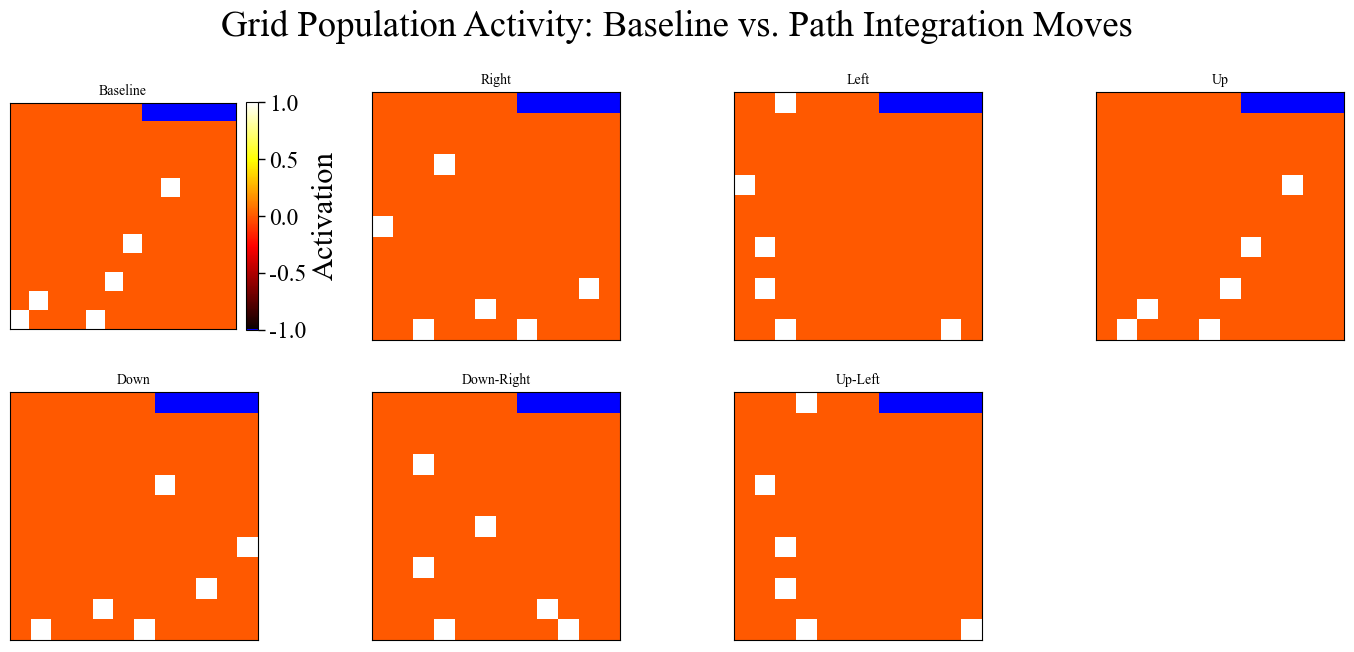

In [3]:
# 可视化当前 g 及其在六个动作下的群体神经元活动
from matplotlib.colors import ListedColormap


# 随机给一个位置索引
gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
place_idx = 1500
g = gbook_flattened[:, place_idx].astype(float).copy()

Ng_current = g.shape[0]
side = int(np.ceil(np.sqrt(Ng_current)))

# 自定义颜色映射：蓝色显示填充区域
_hot = plt.cm.get_cmap('hot')
_custom_colors = ['blue'] + [_hot(i) for i in np.linspace(0, 1, 256)]
custom_cmap = ListedColormap(_custom_colors)

# 缓存置换矩阵，避免重复构造
_WGG_CACHE: dict[tuple[int, int], np.ndarray] = {}

def get_wgg_cached(axis_val: int, direction_val: int) -> np.ndarray:
    """返回（并缓存）指定轴与方向的路径积分矩阵。"""
    key = (axis_val, direction_val)
    if key not in _WGG_CACHE:
        _WGG_CACHE[key] = path_integration_Wgg_2d(lambdas, Ng, axis=axis_val, direction=direction_val)
    return _WGG_CACHE[key]

def advance_state(state: np.ndarray, axis_spec) -> np.ndarray:
    """根据 axis_spec 中的轴/方向定义，对 state 进行一次路径积分。"""
    axis_val, direction_val = axis_spec
    updated = state.copy()
    if axis_val is None:
        return updated
    if isinstance(axis_val, (list, tuple)):
        for ax, di in zip(axis_val, direction_val):
            updated = get_wgg_cached(ax, di) @ updated
    else:
        updated = get_wgg_cached(axis_val, direction_val) @ updated
    return updated

def plot_population_vector(pop_vector: np.ndarray, title: str, ax: plt.Axes) -> None:
    """将长度为 Ng 的向量重排为近似方阵并绘制。"""
    pad = side * side - pop_vector.size
    padded = np.concatenate([pop_vector, np.full(pad, -1)]) if pad else pop_vector
    sheet = padded.reshape(side, side)
    im = ax.imshow(sheet, cmap=custom_cmap, origin='lower', interpolation='nearest', vmin=-1, vmax=1)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    return im

# 定义需要展示的动作：原始状态 + 六个方向
movement_specs = [
    ("Baseline", (None, None)),
    ("Right", (0, 1)),
    ("Left", (0, -1)),
    ("Up", (1, 1)),
    ("Down", (1, -1)),
    ("Down-Right", ([1, 0], [-1, 1])),
    ("Up-Left", ([1, 0], [1, -1])),
]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()
colorbar_handle = None

baseline_state = g.copy()
for idx, (label, axis_spec) in enumerate(movement_specs):
    current_state = advance_state(baseline_state, axis_spec)
    im = plot_population_vector(current_state, label, axes[idx])
    if colorbar_handle is None:
        colorbar_handle = fig.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04, label='Activation')

# 隐藏未使用的轴
for ax in axes[len(movement_specs):]:
    ax.axis('off')

plt.suptitle('Grid Population Activity: Baseline vs. Path Integration Moves', y=0.95)
plt.tight_layout()
plt.show()

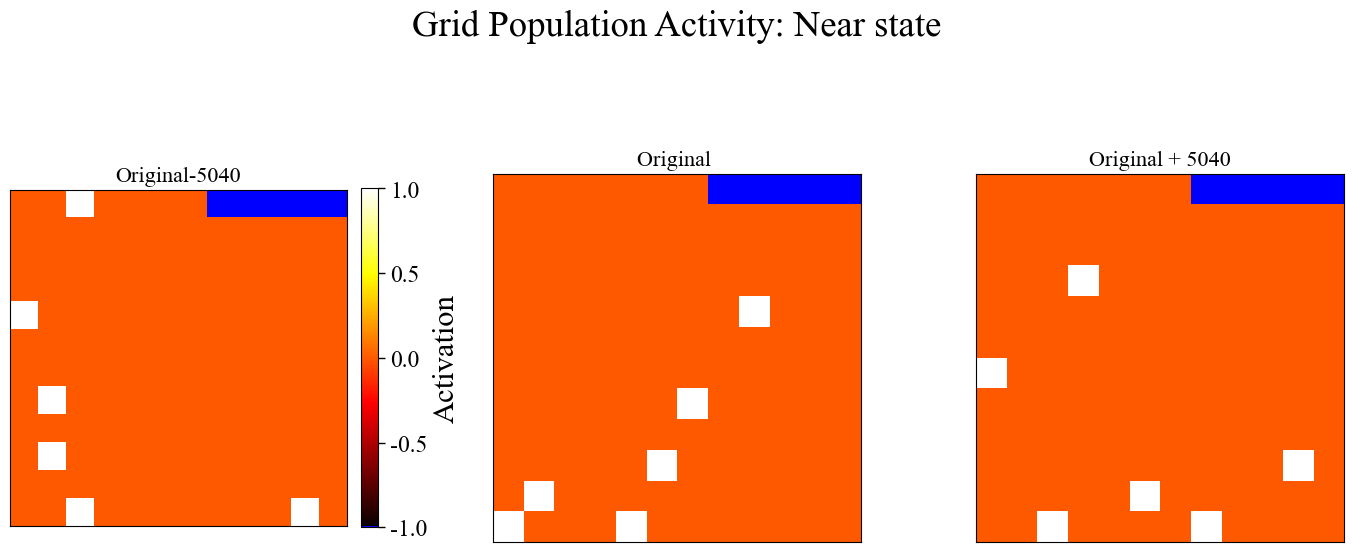

In [13]:
def plot_population_vector(pop_vector: np.ndarray, title: str, ax: plt.Axes) -> None:
    """将长度为 Ng 的向量重排为近似方阵并绘制。"""
    pad = side * side - pop_vector.size
    padded = np.concatenate([pop_vector, np.full(pad, -1)]) if pad else pop_vector
    sheet = padded.reshape(side, side)
    im = ax.imshow(sheet, cmap=custom_cmap, origin='lower', interpolation='nearest', vmin=-1, vmax=1)
    ax.set_title(title, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    return im
fig, axes = plt.subplots(1, 3, figsize=(14, 7))
axes = axes.flatten()
colorbar_handle = None

org_state = g.copy()
label = ["Original-5040", "Original ", "Original + 5040", "Original +3"]
for i in range(1,4):
    if i ==1:
        near_state = gbook_flattened[:, place_idx-5040].astype(float).copy()
        im = plot_population_vector(near_state, label[i-1], axes[i-1])
        if colorbar_handle is None:
            colorbar_handle = fig.colorbar(im, ax=axes[i-1], fraction=0.046, pad=0.04, label='Activation')
    elif i == 2:
        near_state = gbook_flattened[:, place_idx].astype(float).copy()
        im = plot_population_vector(near_state, label[i-1], axes[i-1])
        
        if colorbar_handle is None:
            colorbar_handle = fig.colorbar(im, ax=axes[i-1], fraction=0.046, pad=0.04, label='Activation')
    else:
        near_state = gbook_flattened[:, place_idx+5040].astype(float).copy()
        im = plot_population_vector(near_state, label[i-1], axes[i-1])
        
        if colorbar_handle is None:
            colorbar_handle = fig.colorbar(im, ax=axes[i-1], fraction=0.046, pad=0.04, label='Activation')
# 隐藏未使用的轴
for ax in axes[len(movement_specs):]:
    ax.axis('off')

plt.suptitle('Grid Population Activity: Near state', y=0.95)
plt.tight_layout()
plt.show()

## $\mathcal{Way\,\, of\,\, Sequence\,\, Memory}$

此处主要研究不同沿序列行走的方式与Sensory上信息复原情况。
- `11roomsFig4`:
   1. 更新`p`的方式完全依靠g（`p = nonlin(Wpg @ g, thresh=thresh)`）整个过程完全不依赖sensory的信息；启动的方式也是通过`g[initial_path_location]`。
   2. 依靠直接学习的`p`到`action`的映射(通过MLP)，即在每一个位置上都直接知道下一步该怎么走。
   3. 给定初始的`g`，可自动迭代，走完整个序列。
   4. sensory复原的准确率极高，不管是Hamming距离还是L1范数，居然都是100\%复原。
- `MLP_seq_Fig5`：
   1. 更新p状态时采用了`p = np.sqrt(np.multiply(nonlin(g_in, thresh), relu(s_in)))`，也就是综合考虑了Grid和sensory的输入。
   2. 依靠直接学习的`p`到`action`的映射(通过MLP)，即在每一个位置上都直接知道下一步该怎么走。
   3. 比较Tricky的是，虽然似乎具有走完全部序列的能力，但是实际在脚本中采取的方法却是“逐点评估”（只走了一步）：
   ```python
   for i in path_locations_flattened: 
    ...
        s = sbook_flattened[:,i]
        g = gbook_flattened[:,i]
   ```
      也就是说，并没有靠自己预测的信息进行迭代，仅仅只是通过循环遍历`path_locations`上的每一个点，并预测下一个点的sensory，并评估误差。并且在最后可视化的时候还给出了“记忆序列”和“回忆序列”的比较，感觉却是有点像是cheating。

   4. sensory复原的准确率较高，L1范数在0.0x的水平。
- **注意：** 原本在`11roomsFig4`中的`Ns`(也就是每个`path`上Sensory向量长度为)与`MLP_seq_Fig5`不同，在调整为一致之后，`11roomsFig4`sensory的复原准确率仍然保证原始超高水平。

- 对于我们任务的理解：一开始原本的想法是，只输入sensory，然后每一步都是输入sensory。但是仔细一想发现其实是有问题的，具体考虑：
  $$
  s_i \rightarrow p_i \rightarrow g_i^{noisy} \rightarrow g_i^{clean} \Rightarrow g_{i+1}^{clean} \rightarrow p_{i+1} \rightarrow s_{i+1}
  $$

  $\Rightarrow$表示grid state发生了由$p_i \rightarrow Action$产生的移动。所以再通过$s_{i+1}$得到$p_{i+1}$其实是多余的：$s_{i+1}$本来就是从$p_{i+1}$得到。

  而在我们的任务中，需要明确指定一个沿环形移动的方向：其实，可以直接定义成`path_location`。换言之，`11roomsFig4`基本可以说和我们的任务重合。唯一的差别在于，`11roomsFig4`启动都是通过`g[initial_path_location]`来启动，但是我们的任务应该通过`s[initial_path_location]`来启动。

- 所以下面进行的Visualization，其实差异只是在“启动方式”

In [7]:
# 生成与 11Rooms Fig.4 一致的蛇形路径
# 如果使用和MLP_seq_Fig5相同的路径，可以不用执行这个cell
def build_snake_path(length: int = 10) -> np.ndarray:
    coords: list[tuple[int, int]] = []
    for row in range(length):
        cols = range(length)
        if row % 2 == 1:
            cols = reversed(cols)
        coords.extend((col, row) for col in cols)
    return np.array(coords, dtype=int)

snake_room_offsets = [
    (0, 0),
    (130, 230),
    (55, 390),
    (130, 80),
    (180, 30),
    (280, 380),
    (280, 50),
    (80, 140),
    (230, 180),
    (230, 330),
    (80, 280),
]

snake_room_index = 1  # 默认使用与 11Rooms Fig.4 相同的房间
snake_base_path = build_snake_path(10)
snake_room_offset = np.array(snake_room_offsets[snake_room_index], dtype=int)
snake_path_absolute = snake_base_path + snake_room_offset

print(f"Snake path length: {len(snake_path_absolute)}")
print(f"Snake room offset: {tuple(snake_room_offset)}")

Snake path length: 100
Snake room offset: (np.int64(130), np.int64(230))


In [23]:


nruns=1
Np = 400  #300 #500 #500 #500 #400
lambdas = [3,4,5,7] #[3,4,5,7] #[2,3,5] #[4,5,7] #[3,4,5] #[5,9,13] #[3,4,5] #[3,4,5] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook.shape     # (Ng, Npos, Npos)

module_sizes = np.square(lambdas)
module_gbooks = [np.eye(i) for i in module_sizes]

Wpg = randn(nruns, Np, Ng) 
from numpy.random import randint
    
Npatts=Npos*Npos

gbook_flattened = gbook.reshape(Ng, Npos*Npos)
Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh = 2#0.5 
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  # (nruns, Np, Npos, Npos) 

gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)
Wgp = train_gcpc(pbook_flattened, gbook_flattened,Npatts)

############ 选择与MLP_seq_Fig5 相同的路径数据 ############
# data = np.load("paths/xy_coords_1000_2.npy")
# # data.shape = (2, 1000)

# xcoord = data[0,:]
# ycoord = data[1,:]

# path_locations = []
# x_c = 10 #0 #0 #27 #10 #18 #50 #10 #0 
# y_c = 58 #48 #55 #16 #45 #40 #40 #58 #21  
# for i in range(len(xcoord)):
#     path_locations.append((xcoord[i]+x_c, ycoord[i]+y_c))
#########################################################
############# 选择与11rooms_Fig4 相同的路径数据 ###########
path_locations = [tuple(coord) for coord in snake_path_absolute]
path_locations = [tuple(map(int, coord)) for coord in path_locations]
#########################################################

Npatts = len(path_locations)
Ns = Npatts #3600
x, y = Npos, Npos # Npos, Npos
sbook = sens_nonlin(randn(Ns, x, y))
sbook_flattened = sbook.reshape(Ns, x*y)
sbookinv = np.linalg.pinv(sbook_flattened)
Wps = pbook_flattened[:,:,:Npos*Npos]@sbookinv
# 这是S到P的映射矩阵
# 原本是使用整个空间训练的
Wps_orinal = np.squeeze(Wps)

abook = actions(path_locations)
path_pbook, path_sbook = path_codes(path_locations, pbook, sbook)  

print("path_pbook shape:",path_pbook.shape)
print("path_sbook shape",path_sbook.shape)
path_pbook = np.squeeze(path_pbook)
path_sbook = np.squeeze(path_sbook)
print("path_pbook shape after squeeze:",path_pbook.shape)

# S到P的映射现在使用局部空间
Wps = path_pbook@np.linalg.pinv(path_sbook)
Wsp = sensorymap(path_sbook, path_pbook)
Wsp = np.squeeze(Wsp)

# 为了用伪逆求权重就squeez掉了一个维度
# 现在补回来，主要是保证后面的代码兼容性
# 只有path_pbook需要补，path_sbook不需要
path_pbook = path_pbook.reshape(1, 400, 100)



# learn action mapping from place to actions through perceptron algorithm

n_run = 0
X = path_pbook[n_run].T


y = abook.T
model = MLPClassifier(hidden_layer_sizes=(250), activation="relu", random_state=6, max_iter=12000).fit(X, y)
#500


model.fit(X, y)
model.score(X, y)
print(Wps.shape)
print(Wsp.shape)

    


path_pbook shape: (1, 400, 100)
path_sbook shape (100, 100)
path_pbook shape after squeeze: (400, 100)
(400, 100)
(100, 400)


### 三种序列记忆方式对比实验
对比三种不同的更新策略：
1. **纯Grid驱动（Grid-only）**：启动和更新都只依赖Grid Cell，`p = nonlin(Wpg @ g, thresh)`
2. **Grid+Sensory混合（Grid+Sensory）**：启动依赖Sensory，更新综合Grid和Sensory，`p = √(nonlin(g) ⊙ relu(s))`
3. **Sensory启动Grid驱动（Sensory-initiated Grid）**：启动依赖Sensory获得初始p和g，但后续更新只依赖Grid

In [26]:
# 三种序列记忆方式的实现与对比
run_idx = 0  # 使用 run_idx 避免与 n_run 混淆
nsteps = len(path_locations)

# 预缓存路径积分矩阵，避免重复构造
Wgg_cache = {}
def get_Wgg(axis_value, direction_value):
    key = (axis_value, direction_value)
    if key not in Wgg_cache:
        Wgg_cache[key] = path_integration_Wgg_2d(lambdas, Ng, axis=axis_value, direction=direction_value)
    return Wgg_cache[key]

# 获取初始位置的 grid state
initial_coord_idx = path_locations[0][0] * Npos + path_locations[0][1]
g_init_from_coord = gbook_flattened[:, initial_coord_idx].astype(float).copy()

# 预计算真实的 grid 轨迹，便于误差评估
path_indices = [x * Npos + y for (x, y) in path_locations]
true_path_gcodes = gbook_flattened[:, path_indices]  # (Ng, nsteps)

# 压缩 Wsp 的 run 维度，确保推理阶段与 Fig4 一致
Wsp_full = sensorymap(path_sbook, path_pbook)
Wsp = Wsp_full[run_idx] if Wsp_full.ndim == 3 else Wsp_full  # (Ns, Np)
Wsp_inv = np.linalg.pinv(Wsp)  # (Np, Ns)

print("=" * 60)
print("方法1: 纯Grid驱动 (Grid-only, Grid启动)")
print("=" * 60)
g1 = g_init_from_coord.copy()
err_s1 = np.zeros(nsteps)
err_p1 = np.zeros(nsteps)
err_g1 = np.zeros(nsteps)
decoded_path1 = []
predicted_actions1 = np.zeros(nsteps, dtype=int)

for step in tqdm(range(nsteps), desc="Grid-only navigation"):
    decoded_path1.append(gcode_to_coord(g1[None, :, None], gbook_flattened, Npos))
    p1 = nonlin(Wpg @ g1, thresh=thresh)  # (nruns, Np)
    p1_run = p1[run_idx]
    s1_run = np.sign(Wsp @ p1_run)

    true_s = path_sbook[:, step]
    err_s1[step] = np.sum(np.abs(s1_run - true_s)) / (2 * Ns)

    true_p = path_pbook[:, :, step][run_idx]
    err_p1[step] = np.sum(np.abs(p1_run - true_p)) / (2 * Np)

    true_g = true_path_gcodes[:, step]
    err_g1[step] = np.sum(np.abs(g1 - true_g)) / (2 * Ng)

    action = int(model.predict(p1_run[None, :])[0])
    predicted_actions1[step] = action
    axis, direction = oneDaction_mapping(action)
    if axis is not None:
        if isinstance(axis, (list, tuple)):
            for sub_axis, sub_direction in zip(axis, direction):
                g1 = get_Wgg(sub_axis, sub_direction) @ g1
        else:
            g1 = get_Wgg(axis, direction) @ g1

print(f"  Sensory mean: {err_s1.mean():.6f} | max: {err_s1.max():.6f}")
print(f"  Place   mean: {err_p1.mean():.6f} | max: {err_p1.max():.6f}")
print(f"  Grid    mean: {err_g1.mean():.6f} | max: {err_g1.max():.6f}")

print("\n" + "=" * 60)
print("方法2: Sensory启动Grid驱动 (Sensory-initiated, Grid-driven)")
print("=" * 60)
s2_init = path_sbook[:, 0]
# 之前用的Wsp_inv
# 之前还用的是np.sign
p2_init = Wps @ s2_init
gin2 = Wgp @ p2_init[None, :, None]  # (nruns, Ng, 1)
g2 = module_wise_NN_2d(gin2, module_gbooks, module_sizes)[:, :, 0][run_idx]
err_s2 = np.zeros(nsteps)
err_p2 = np.zeros(nsteps)
err_g2 = np.zeros(nsteps)
decoded_path2 = []
predicted_actions2 = np.zeros(nsteps, dtype=int)

for step in tqdm(range(nsteps), desc="Sensory-init Grid navigation"):
    decoded_path2.append(gcode_to_coord(g2[None, :, None], gbook_flattened, Npos))
    p2 = nonlin(Wpg @ g2, thresh=thresh)
    p2_run = p2[run_idx]
    s2_run = np.sign(Wsp @ p2_run)

    true_s = path_sbook[:, step]
    err_s2[step] = np.sum(np.abs(s2_run - true_s)) / (2 * Ns)

    true_p = path_pbook[:, :, step][run_idx]
    err_p2[step] = np.sum(np.abs(p2_run - true_p)) / (2 * Np)

    true_g = true_path_gcodes[:, step]
    err_g2[step] = np.sum(np.abs(g2 - true_g)) / (2 * Ng)

    action = int(model.predict(p2_run[None, :])[0])
    predicted_actions2[step] = action
    axis, direction = oneDaction_mapping(action)
    if axis is not None:
        if isinstance(axis, (list, tuple)):
            for sub_axis, sub_direction in zip(axis, direction):
                g2 = get_Wgg(sub_axis, sub_direction) @ g2
        else:
            g2 = get_Wgg(axis, direction) @ g2

print(f"  Sensory mean: {err_s2.mean():.6f} | max: {err_s2.max():.6f}")
print(f"  Place   mean: {err_p2.mean():.6f} | max: {err_p2.max():.6f}")
print(f"  Grid    mean: {err_g2.mean():.6f} | max: {err_g2.max():.6f}")

print("\n" + "=" * 60)
print("方法3: Sensory和Grid混合启动，Grid驱动 (Mixed-init, Grid-driven)")
print("=" * 60)
s3_init = path_sbook[:, 0]
p3_from_s = relu(Wps @ s3_init)
gin_from_g = Wpg[run_idx] @ g_init_from_coord
p3_from_g = nonlin(gin_from_g, thresh=thresh)
p3_init = np.sqrt(np.multiply(p3_from_g, p3_from_s))
gin3 = Wgp @ p3_init[None, :, None]
g3 = module_wise_NN_2d(gin3, module_gbooks, module_sizes)[:, :, 0][run_idx]
err_s3 = np.zeros(nsteps)
err_p3 = np.zeros(nsteps)
err_g3 = np.zeros(nsteps)
decoded_path3 = []
predicted_actions3 = np.zeros(nsteps, dtype=int)

for step in tqdm(range(nsteps), desc="Mixed-init Grid navigation"):
    decoded_path3.append(gcode_to_coord(g3[None, :, None], gbook_flattened, Npos))
    p3 = nonlin(Wpg @ g3, thresh=thresh)
    p3_run = p3[run_idx]
    s3_run = np.sign(Wsp @ p3_run)

    true_s = path_sbook[:, step]
    err_s3[step] = np.sum(np.abs(s3_run - true_s)) / (2 * Ns)

    true_p = path_pbook[:, :, step][run_idx]
    err_p3[step] = np.sum(np.abs(p3_run - true_p)) / (2 * Np)

    true_g = true_path_gcodes[:, step]
    err_g3[step] = np.sum(np.abs(g3 - true_g)) / (2 * Ng)

    action = int(model.predict(p3_run[None, :])[0])
    predicted_actions3[step] = action
    axis, direction = oneDaction_mapping(action)
    if axis is not None:
        if isinstance(axis, (list, tuple)):
            for sub_axis, sub_direction in zip(axis, direction):
                g3 = get_Wgg(sub_axis, sub_direction) @ g3
        else:
            g3 = get_Wgg(axis, direction) @ g3

print(f"  Sensory mean: {err_s3.mean():.6f} | max: {err_s3.max():.6f}")
print(f"  Place   mean: {err_p3.mean():.6f} | max: {err_p3.max():.6f}")
print(f"  Grid    mean: {err_g3.mean():.6f} | max: {err_g3.max():.6f}")

results = {
    'method1': {
        'name': 'Grid-only',
        'err_s': err_s1,
        'err_p': err_p1,
        'err_g': err_g1,
        'color': '#2E86AB',
        'linestyle': '-'
    },
    'method2': {
        'name': 'Sensory_Start',
        'err_s': err_s2,
        'err_p': err_p2,
        'err_g': err_g2,
        'color': '#A23B72',
        'linestyle': '--'
    },
    'method3': {
        'name': 'Sensory_Grid_mix',
        'err_s': err_s3,
        'err_p': err_p3,
        'err_g': err_g3,
        'color': '#F18F01',
        'linestyle': '-.'
    }
}

print("\n" + "=" * 60)
print("实验完成！三种方法的重构误差已计算完毕。")
print("=" * 60)

for method_key, method_data in results.items():
    print(f"\n{method_data['name']}:")
    for label, err_array in [('Sensory', method_data['err_s']), ('Place', method_data['err_p']), ('Grid', method_data['err_g'])]:
        max_idx = int(np.argmax(err_array))
        min_idx = int(np.argmin(err_array))
        print(f"  {label:<7}最大误差: {err_array[max_idx]:.6f} at step {max_idx}")
        print(f"  {label:<7}最小误差: {err_array[min_idx]:.6f} at step {min_idx}")

方法1: 纯Grid驱动 (Grid-only, Grid启动)


Grid-only navigation: 100%|██████████| 100/100 [00:01<00:00, 55.98it/s]


  Sensory mean: 0.000000 | max: 0.000000
  Place   mean: 0.000000 | max: 0.000000
  Grid    mean: 0.000000 | max: 0.000000

方法2: Sensory启动Grid驱动 (Sensory-initiated, Grid-driven)


Sensory-init Grid navigation: 100%|██████████| 100/100 [00:01<00:00, 59.90it/s]


  Sensory mean: 0.000000 | max: 0.000000
  Place   mean: 0.000000 | max: 0.000000
  Grid    mean: 0.000000 | max: 0.000000

方法3: Sensory和Grid混合启动，Grid驱动 (Mixed-init, Grid-driven)


Mixed-init Grid navigation: 100%|██████████| 100/100 [00:01<00:00, 61.97it/s]

  Sensory mean: 0.000000 | max: 0.000000
  Place   mean: 0.000000 | max: 0.000000
  Grid    mean: 0.000000 | max: 0.000000

实验完成！三种方法的重构误差已计算完毕。

Grid-only:
  Sensory最大误差: 0.000000 at step 0
  Sensory最小误差: 0.000000 at step 0
  Place  最大误差: 0.000000 at step 51
  Place  最小误差: 0.000000 at step 59
  Grid   最大误差: 0.000000 at step 0
  Grid   最小误差: 0.000000 at step 0

Sensory_Start:
  Sensory最大误差: 0.000000 at step 0
  Sensory最小误差: 0.000000 at step 0
  Place  最大误差: 0.000000 at step 51
  Place  最小误差: 0.000000 at step 59
  Grid   最大误差: 0.000000 at step 0
  Grid   最小误差: 0.000000 at step 0

Sensory_Grid_mix:
  Sensory最大误差: 0.000000 at step 0
  Sensory最小误差: 0.000000 at step 0
  Place  最大误差: 0.000000 at step 51
  Place  最小误差: 0.000000 at step 59
  Grid   最大误差: 0.000000 at step 0
  Grid   最小误差: 0.000000 at step 0


#### 可视化对比：三种方法的Sensory重构误差

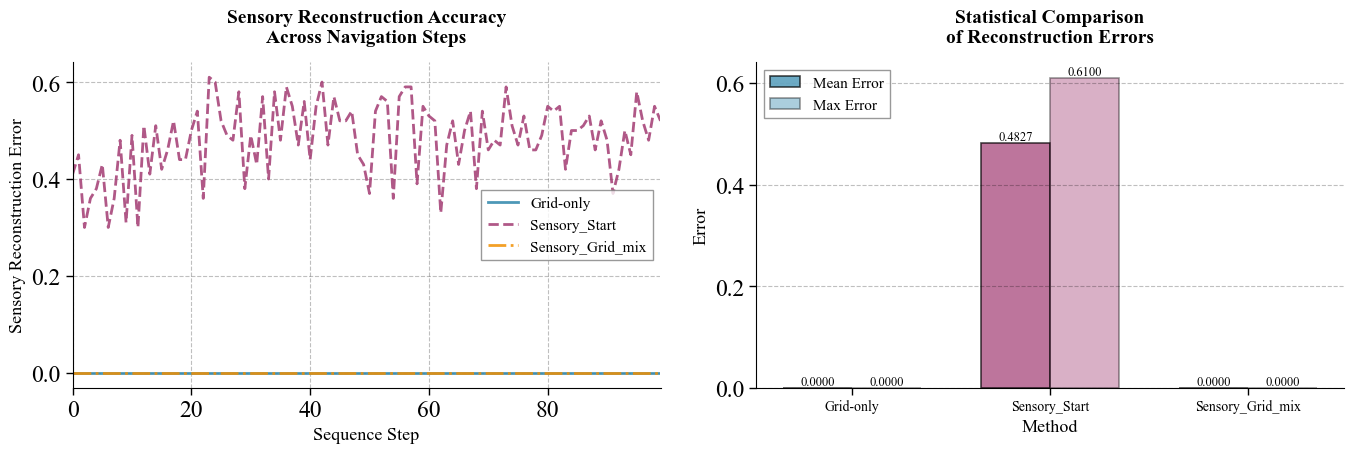


详细统计信息

Grid-only:
  Mean: 0.000000
  Max: 0.000000
  Min: 0.000000
  Std:   0.000000
  完美重构步数: 100/100 (100.00%)

Sensory_Start:
  Mean: 0.482700
  Max: 0.610000
  Min: 0.300000
  Std:   0.075031
  完美重构步数: 0/100 (0.00%)

Sensory_Grid_mix:
  Mean: 0.000000
  Max: 0.000000
  Min: 0.000000
  Std:   0.000000
  完美重构步数: 100/100 (100.00%)


In [ ]:
# 可视化：三种方法的Sensory重构误差对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：完整误差曲线
ax1 = axes[0]
for method_key, method_data in results.items():
    ax1.plot(range(nsteps), method_data['err_s'], 
             label=method_data['name'],
             color=method_data['color'],
             linestyle=method_data['linestyle'],
             linewidth=2.0,
             alpha=0.85)

ax1.set_xlabel('Sequence Step', fontsize=13, fontweight='normal')
ax1.set_ylabel('Sensory Reconstruction Error', fontsize=13, fontweight='normal')
ax1.set_title('Sensory Reconstruction Accuracy\nAcross Navigation Steps', 
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='best', frameon=True, shadow=False, 
           fancybox=False, fontsize=11, edgecolor='gray')
ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(0, nsteps-1)

# 右图：统计柱状图
ax2 = axes[1]
methods = [results[k]['name'] for k in ['method1', 'method2', 'method3']]
mean_errs = [results[k]['err_s'].mean() for k in ['method1', 'method2', 'method3']]
max_errs = [results[k]['err_s'].max() for k in ['method1', 'method2', 'method3']]
colors = [results[k]['color'] for k in ['method1', 'method2', 'method3']]

x_pos = np.arange(len(methods))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, mean_errs, width, 
                label='Mean Error', color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)
bars2 = ax2.bar(x_pos + width/2, max_errs, width, 
                label='Max Error', color=colors, alpha=0.4, edgecolor='black', linewidth=1.2)

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='normal')

ax2.set_xlabel('Method', fontsize=13, fontweight='normal')
ax2.set_ylabel('Error', fontsize=13, fontweight='normal')
ax2.set_title('Statistical Comparison\nof Reconstruction Errors', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods, fontsize=10)
ax2.legend(loc='upper left', frameon=True, shadow=False, 
           fancybox=False, fontsize=11, edgecolor='gray')
ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# ===== 8) 可视化C：给定 p 槽位，经 Wsp 重建 s_hat，与三个 effect 的相似度（耦合/串扰） =====
fig, axes = plt.subplots(K, 1, figsize=(9, 7), sharex=True)
T = wsp_sim.shape[0]
for k, ax in enumerate(axes):
    for j, e2 in enumerate(effects_order):
        ax.plot(wsp_sim[:, k, j], linewidth=1.6, label=e2)
    ax.axvline(switch_step, color='crimson', linewidth=1.2, alpha=0.35)
    ax.set_ylabel(str(candidate_slots[k]))
    ax.legend(frameon=False, fontsize=9, ncol=3, loc='upper right')
axes[-1].set_xlabel('time step')
plt.tight_layout()
plt.show()

# 打印详细统计信息
print("\n" + "=" * 70)
print("详细统计信息")
print("=" * 70)
for method_key, method_data in results.items():
    print(f"\n{method_data['name']}:")
    print(f"  Mean: {method_data['err_s'].mean():.6f}")
    print(f"  Max: {method_data['err_s'].max():.6f}")
    print(f"  Min: {method_data['err_s'].min():.6f}")
    print(f"  Std:   {method_data['err_s'].std():.6f}")
    # 计算完美重构的步数 (误差为0)
    perfect_steps = np.sum(method_data['err_s'] == 0)
    print(f"  完美重构步数: {perfect_steps}/{nsteps} ({perfect_steps/nsteps*100:.2f}%)")
print("=" * 70)

#### 可视化对比：Grid 重构误差

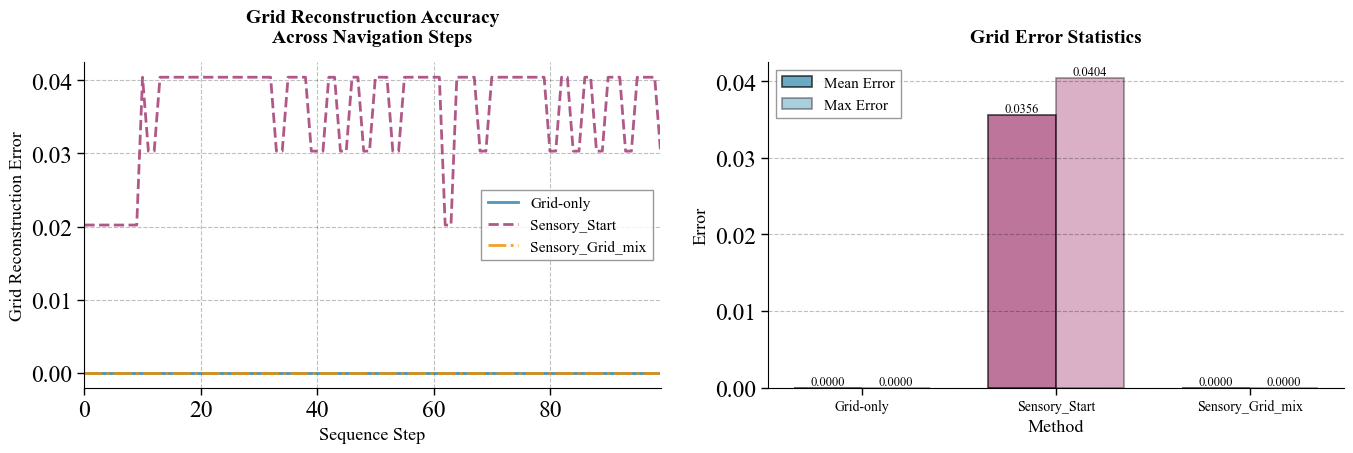


Grid 误差详细统计

Grid-only:
  Mean: 0.000000
  Max:  0.000000
  Min:  0.000000
  Std:  0.000000

Sensory_Start:
  Mean: 0.035556
  Max:  0.040404
  Min:  0.020202
  Std:  0.007068

Sensory_Grid_mix:
  Mean: 0.000000
  Max:  0.000000
  Min:  0.000000
  Std:  0.000000


In [11]:
# Grid 重构误差对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：Grid 误差曲线
ax1 = axes[0]
for method_key, method_data in results.items():
    ax1.plot(range(nsteps), method_data['err_g'],
             label=method_data['name'],
             color=method_data['color'],
             linestyle=method_data['linestyle'],
             linewidth=2.0,
             alpha=0.85)

ax1.set_xlabel('Sequence Step', fontsize=13, fontweight='normal')
ax1.set_ylabel('Grid Reconstruction Error', fontsize=13, fontweight='normal')
ax1.set_title('Grid Reconstruction Accuracy\nAcross Navigation Steps',
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='best', frameon=True, shadow=False,
           fancybox=False, fontsize=11, edgecolor='gray')
ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(0, nsteps - 1)

# 右图：Grid 误差统计
ax2 = axes[1]
methods = [results[k]['name'] for k in ['method1', 'method2', 'method3']]
mean_errs_g = [results[k]['err_g'].mean() for k in ['method1', 'method2', 'method3']]
max_errs_g = [results[k]['err_g'].max() for k in ['method1', 'method2', 'method3']]
colors = [results[k]['color'] for k in ['method1', 'method2', 'method3']]

x_pos = np.arange(len(methods))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, mean_errs_g, width,
                label='Mean Error', color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)
bars2 = ax2.bar(x_pos + width/2, max_errs_g, width,
                label='Max Error', color=colors, alpha=0.4, edgecolor='black', linewidth=1.2)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='normal')

ax2.set_xlabel('Method', fontsize=13, fontweight='normal')
ax2.set_ylabel('Error', fontsize=13, fontweight='normal')
ax2.set_title('Grid Error Statistics',
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods, fontsize=10)
ax2.legend(loc='upper left', frameon=True, shadow=False,
           fancybox=False, fontsize=11, edgecolor='gray')
ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print('\n' + '=' * 70)
print('Grid 误差详细统计')
print('=' * 70)
for method_key, method_data in results.items():
    print(f"\n{method_data['name']}:" )
    print(f"  Mean: {method_data['err_g'].mean():.6f}")
    print(f"  Max:  {method_data['err_g'].max():.6f}")
    print(f"  Min:  {method_data['err_g'].min():.6f}")
    print(f"  Std:  {method_data['err_g'].std():.6f}")
print('=' * 70)

#### 可视化对比：Place 重构误差

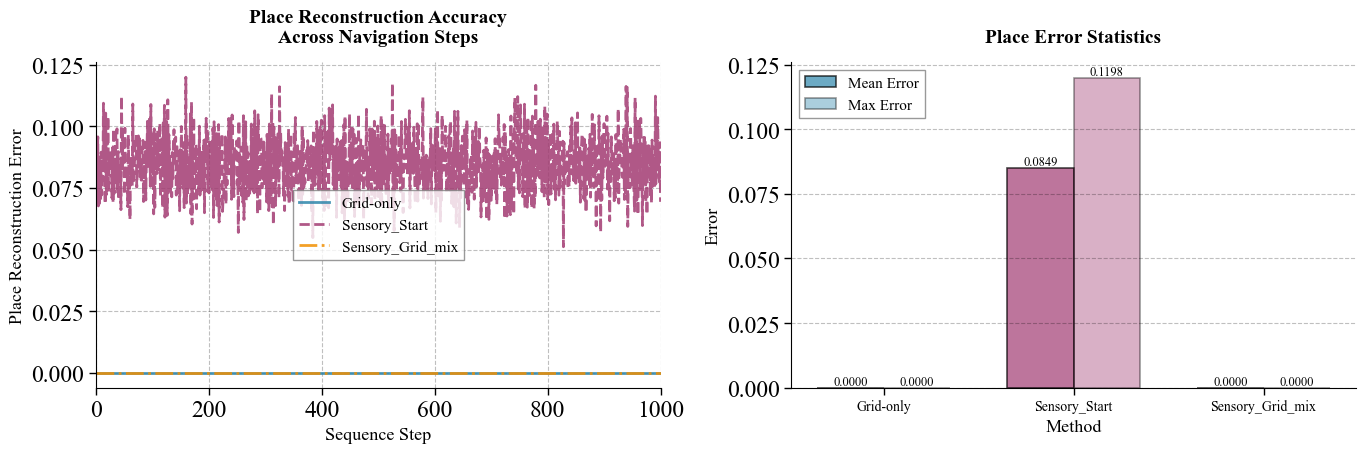


Place 误差详细统计

Grid-only:
  Mean: 0.000000
  Max:  0.000000
  Min:  0.000000
  Std:  0.000000

Sensory_Start:
  Mean: 0.084938
  Max:  0.119849
  Min:  0.051120
  Std:  0.011822

Sensory_Grid_mix:
  Mean: 0.000000
  Max:  0.000000
  Min:  0.000000
  Std:  0.000000


In [16]:
# Place 重构误差对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：Place 误差曲线
ax1 = axes[0]
for method_key, method_data in results.items():
    ax1.plot(range(nsteps), method_data['err_p'],
             label=method_data['name'],
             color=method_data['color'],
             linestyle=method_data['linestyle'],
             linewidth=2.0,
             alpha=0.85)

ax1.set_xlabel('Sequence Step', fontsize=13, fontweight='normal')
ax1.set_ylabel('Place Reconstruction Error', fontsize=13, fontweight='normal')
ax1.set_title('Place Reconstruction Accuracy\nAcross Navigation Steps',
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='best', frameon=True, shadow=False,
           fancybox=False, fontsize=11, edgecolor='gray')
ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(0, nsteps - 1)

# 右图：Place 误差统计
ax2 = axes[1]
methods = [results[k]['name'] for k in ['method1', 'method2', 'method3']]
mean_errs_p = [results[k]['err_p'].mean() for k in ['method1', 'method2', 'method3']]
max_errs_p = [results[k]['err_p'].max() for k in ['method1', 'method2', 'method3']]
colors = [results[k]['color'] for k in ['method1', 'method2', 'method3']]

x_pos = np.arange(len(methods))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, mean_errs_p, width,
                label='Mean Error', color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)
bars2 = ax2.bar(x_pos + width/2, max_errs_p, width,
                label='Max Error', color=colors, alpha=0.4, edgecolor='black', linewidth=1.2)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='normal')

ax2.set_xlabel('Method', fontsize=13, fontweight='normal')
ax2.set_ylabel('Error', fontsize=13, fontweight='normal')
ax2.set_title('Place Error Statistics',
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods, fontsize=10)
ax2.legend(loc='upper left', frameon=True, shadow=False,
           fancybox=False, fontsize=11, edgecolor='gray')
ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print('\n' + '=' * 70)
print('Place 误差详细统计')
print('=' * 70)
for method_key, method_data in results.items():
    print(f"\n{method_data['name']}:" )
    print(f"  Mean: {method_data['err_p'].mean():.6f}")
    print(f"  Max:  {method_data['err_p'].max():.6f}")
    print(f"  Min:  {method_data['err_p'].min():.6f}")
    print(f"  Std:  {method_data['err_p'].std():.6f}")
print('=' * 70)

## 分析为什么不同路径会导致不同的重建率

首先，仔细研究代码后，发现代码中存在许多confusing（Tricky？）的地方
- 代码中有两个$N_{patts}$。补充材料中还常常提到$N_{patts}$。经过严密分析后得到应该是指第二次出现的$N_{patts}$:希望记住的pattern数量。在下面的表述中，`Npos*Npos`会被明确指明，非以`Npatts`的形式表示。
- Supplement中（如下面的D.1）提到的$W_{hs}$矩阵的获得方式应该通过`path_pbook`和`path_sbook`获得，并不应该通过`Wps = pbook_flattened[:,:,:Npos*Npos]@sbookinv`得到，这样相当于“我们已经探索了整个空间，用所有 `Npos*Npos` 个位置训练了 `Wps(Whs)`”，但是补充材料CD部分的基本假设都是“我们只探索了 $N_{patts}$ 个位置，只用这 $N_{patts}$ 个 xx 训练 xx”


Supplement:
D.1:**D.1 Perfect Reconstruction of Hippocampal States Through Heteroassociative Pseudoinverse Learning**
>The projection of the learned sensory inputs onto the hippocampus is given by $W_{hs}S = HS^+S = HΛS$, where $Λ_S = S^+S$ is an orthogonal projection operator onto the range of $S^T$ . If Ns ≥ Npatts, S has linearly independent columns, and ΛS = I, the identity matrix. Thus, $W_{hs}S= H$, i.e., cuing any memorized patterns results in accurate reconstruction of the corresponding hippocampal scaffold state

此处含义即为：$N_s$(sensory神经元数量)大于等于$N_{patts}$（希望记住的模式数量），那么S就有线性无关的列，最后就能让$W_{hs}S= H$，也就是实现完美重建H。这里的W_{hs}应该是(N_h,N_s),S则是(N_s,Npatts),H应该是(N_h,N_{patts})，分别对应`path_sbook,pathpbook`，只是代码中却是`Wps = pbook_flattened[:,:,:Npos*Npos]@sbookinv`。

这里的推导其实在当前代码下是不成立的，因为W_{hs}和N_{patts}无关。但是刚巧，我们关心的是S的重建，所以这一部分可以暂时按下不表。

D.2:**Perfect Reconstruction of Nh Sensory States Through Heteroassociative Pseudoinverse Learning**

>To show that up to Npatts ≤ Nh sensory inputs can be perfectly reconstructed from hippocampal states through VectorHaSH, we require that the matrix of fixed point hippocampal states H be strongly full rank.i.e., all submatrices formed by considred a subset of columns of the matrix H are full rank......The projection of the hippocampus states onto the sensory layer is given by $W_{sh}H = SH^+H = SΛ_H$, where $Λ_H = H^+H$ is an orthogonal projection operator onto the range of $H^T$ . Since H is strongly full rank (as justified above), thus for up to Npatts ≤ Nh, the projection operator $Λ_H$ will equal I, the identity matrix. Thus $W_{sh}P = S$.

这里提到了两个条件：
1. Npatts ≤ Nh。
2. H必须是强满秩的。所以，只要H强满秩，就有Λ_H = H^+H = I，进而有W_{sh}P = S。H同样是`path_pbook`。

这里的下文同时提到了Fig S9，对于`path_pbook`这个矩阵，rank为min{N_patts,N_h}，所以其实1是2的必要条件，2是1的更强条件。

根据目前的代码分析，对于`MLP_Seq_Fig5`的情况，有Npatts > Nh，所以强满秩的必要条件已经被破坏；对于`11rooms_Fig4`的情况，能实现完美重建，也就是说，H是强满秩的。接下来只需要验证该观点即可





In [3]:

nruns=1
Np = 400  #300 #500 #500 #500 #400
lambdas = [3,4,5,7] #[3,4,5,7] #[2,3,5] #[4,5,7] #[3,4,5] #[5,9,13] #[3,4,5] #[3,4,5] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook.shape     # (Ng, Npos, Npos)

module_sizes = np.square(lambdas)
module_gbooks = [np.eye(i) for i in module_sizes]

Wpg = randn(nruns, Np, Ng) 
from numpy.random import randint
    

gbook_flattened = gbook.reshape(Ng, Npos*Npos)
Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh = 2#0.5 
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  # (nruns, Np, Npos, Npos) 

gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)
## 下一行原本用Npatts，改为Npos*Npos，为了防止歧义
Wgp = train_gcpc(pbook_flattened, gbook_flattened,Npos*Npos)


############# 选择与11rooms_Fig4 相同的路径数据 ###########
path_locations_4 = [tuple(coord) for coord in snake_path_absolute]
path_locations_4 = [tuple(map(int, coord)) for coord in path_locations_4]

Npatts_4 = len(path_locations_4)
Ns_4 = Npatts_4 
x, y = Npos, Npos # Npos, Npos
sbook = sens_nonlin(randn(Ns_4, x, y))
sbook_flattened = sbook.reshape(Ns_4, x*y)
sbookinv = np.linalg.pinv(sbook_flattened)
Wps = pbook_flattened[:,:,:Npos*Npos]@sbookinv
path_pbook_4, path_sbook_4 = path_codes(path_locations_4, pbook, sbook)  


############ 选择与MLP_seq_Fig5 相同的路径数据 ############
data = np.load("paths/xy_coords_1000_2.npy")
# data.shape = (2, 1000)

xcoord = data[0,:]
ycoord = data[1,:]

path_locations_5 = []
x_c = 10 #0 #0 #27 #10 #18 #50 #10 #0 
y_c = 58 #48 #55 #16 #45 #40 #40 #58 #21  
for i in range(len(xcoord)):
    path_locations_5.append((xcoord[i]+x_c, ycoord[i]+y_c))


Npatts_5 = len(path_locations_5)
Ns_5 = Npatts_5 #3600
x, y = Npos, Npos # Npos, Npos
sbook = sens_nonlin(randn(Ns_5, x, y))
sbook_flattened = sbook.reshape(Ns_5, x*y)
sbookinv = np.linalg.pinv(sbook_flattened)
Wps = pbook_flattened[:,:,:Npos*Npos]@sbookinv
path_pbook_5, path_sbook_5 = path_codes(path_locations_5, pbook, sbook)  

In [4]:
path_pbook_4 = np.squeeze(path_pbook_4) 
path_pbook_5 = np.squeeze(path_pbook_5)
print(path_pbook_4.shape)
print(path_pbook_5.shape)
print(Ns_4)
print(Ns_5)

(400, 100)
(400, 1001)
100
1001


#### 检验强满秩与求秩
- 这里只能通过抽样的方式来检验，因为完全检验是不可能的
- 假如矩阵有100列，那么需要检验的子矩阵数目为$2^{100}-1$

In [17]:
import numpy as np
import time

def check_strong_full_rank_approx(matrix, n_samples=10000, tol=1e-10):
    """
    通过随机抽样来近似检验矩阵是否为强满秩。

    参数:
    matrix (np.ndarray): 输入矩阵，形状为
    n_samples (int): 要抽样的子矩阵数量。
    tol (float): 计算秩时的容差。

    返回:
    tuple: (bool, dict)
        - bool: 如果所有抽样的子矩阵都是满秩的，则为 True。
        - dict: 包含检验细节的字典。
    """
    rows, cols = matrix.shape
    

    #### 如果要用来检查pbook，快速检查都要禁用
    #### 因为快速检查是肯定不满足的
    # 1. 快速检查：如果列数 > 行数，不可能强满秩
    # if cols > rows:
    #     return False, {"reason": f"Cols ({cols}) > Rows ({rows})", "overall_rank": np.linalg.matrix_rank(matrix, tol)}

    # 2. 快速检查：整体矩阵的秩
    overall_rank = np.linalg.matrix_rank(matrix, tol)
    # if overall_rank < cols:
    #     return False, {"reason": f"Overall rank ({overall_rank}) < Cols ({cols})", "overall_rank": overall_rank}

    # 3. 随机抽样检验
    start_time = time.time()
    for i in range(n_samples):
        # 随机选择一个子集大小 k (从 1 到 cols)
        # k = np.random.randint(1, cols + 1)
        k = 200
        
        # 随机选择 k 列
        cols_idx = np.random.choice(cols, k, replace=False)
        
        # 提取子矩阵
        submatrix = matrix[:, cols_idx]
        
        # 计算子矩阵的秩
        subrank = np.linalg.matrix_rank(submatrix, tol)
        
        # 如果子矩阵不是满秩，立即返回 False
        if subrank < k:
            elapsed_time = time.time() - start_time
            return False, {
                "reason": f"Found a rank-deficient submatrix of size {k} with rank {subrank}",
                "samples_checked": i + 1,
                "time_elapsed_sec": elapsed_time,
                "overall_rank": overall_rank
            }

    # 如果所有样本都通过了检验
    elapsed_time = time.time() - start_time
    return True, {
        "reason": f"All {n_samples} random submatrices were full rank.",
        "time_elapsed_sec": elapsed_time,
        "overall_rank": overall_rank
    }

# --- 主程序 ---

# 假设 path_pbook_4 和 path_pbook_5 已经存在
# 为了演示，我们创建一些示例数据
# Np = 400, Npatts_4 = 100
# path_pbook_4 = np.random.rand(400, 100) 
# path_pbook_5 = np.random.rand(400, 1000) # 假设第二个路径更长

# 检查 path_pbook_4
# print("Checking path_pbook_4 (approximate)...")
# is_sfr_4, info_4 = check_strong_full_rank_approx(path_pbook_4, n_samples=5000)
# print(f"Result: {is_sfr_4}")
# print(f"Details: {info_4}\n")

# # 检查 path_pbook_5
# print("Checking path_pbook_5 (approximate)...")
# is_sfr_5, info_5 = check_strong_full_rank_approx(path_pbook_5, n_samples=5000)
# print(f"Result: {is_sfr_5}")
# print(f"Details: {info_5}")


#### 检查pbook是否强满秩

In [18]:
print("Checking pbook (approximate)...")
print(np.squeeze(pbook_flattened).shape)
is_sfr, info = check_strong_full_rank_approx(np.squeeze(pbook_flattened), n_samples=50000)
print(f"Result: {is_sfr}")
print(f"Details: {info}\n")

Checking pbook (approximate)...
(342, 176400)
Result: True
Details: {'reason': 'All 50000 random submatrices were full rank.', 'time_elapsed_sec': 504.6856710910797, 'overall_rank': np.int64(341)}

